In [203]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import pickle

# Collect Data

Starting time: 2018-12-23 06:19:00.684924+00:00


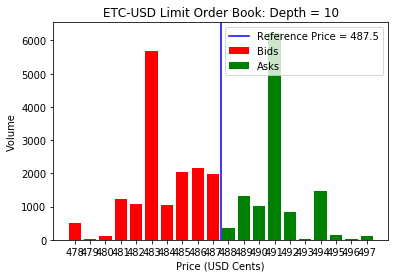

Reference Price: 487.5
---------------------------------------
First 10 Bids: 
478, 513.32169
479, 10.058
480, 115.258
481, 1219.93806141
482, 1079.44864163
483, 5690.64860072
484, 1044.26580999
485, 2036.82835309
486, 2162.94134543
487, 1992.38494076
---------------------------------------
First 10 Asks: 
488, 350.6803041
489, 1318.79202167
490, 1018.12588706
491, 6233.39414514
492, 835.2232479
493, 26.33785052
494, 1483.358
495, 139.86105619
496, 27.78542001
497, 114.49735792
---------------------------------------


Update: ('sell', '4.88000000', '237.7746041')
Time: 2018-12-23T06:19:06.653Z
---------------------------------------
Update: ('buy', '4.86000000', '2224.34134543')
Time: 2018-12-23T06:19:06.681Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:19:07.273Z
---------------------------------------
Update: ('sell', '4.92000000', '1335.2232479')
Time: 2018-12-23T06:19:07.360Z
---------------------------------------
Upd

Update: ('sell', '4.91000000', '6233.39414514')
Time: 2018-12-23T06:19:27.469Z
---------------------------------------
Update: ('buy', '4.85000000', '1536.82835309')
Time: 2018-12-23T06:19:27.597Z
---------------------------------------
Update: ('buy', '4.84000000', '1732.96580999')
Time: 2018-12-23T06:19:27.604Z
---------------------------------------
Update: ('buy', '4.84000000', '1790.06580999')
Time: 2018-12-23T06:19:28.698Z
---------------------------------------
Update: ('buy', '4.84000000', '1843.36580999')
Time: 2018-12-23T06:19:28.700Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:19:28.725Z
---------------------------------------
Update: ('sell', '4.92000000', '1335.2232479')
Time: 2018-12-23T06:19:28.829Z
---------------------------------------
Update: ('sell', '4.92000000', '835.2232479')
Time: 2018-12-23T06:19:29.046Z
---------------------------------------
Update: ('sell', '4.91000000', '6233.39414514')
Time: 2

Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:19:39.916Z
---------------------------------------
Update: ('sell', '4.92000000', '1345.4519003')
Time: 2018-12-23T06:19:40.006Z
---------------------------------------
Update: ('sell', '4.92000000', '845.4519003')
Time: 2018-12-23T06:19:40.141Z
---------------------------------------
Update: ('sell', '4.91000000', '6233.39414514')
Time: 2018-12-23T06:19:40.228Z
---------------------------------------
Update: ('sell', '4.89000000', '1374.55602167')
Time: 2018-12-23T06:19:41.179Z
---------------------------------------
Update: ('buy', '4.83000000', '5096.84314785')
Time: 2018-12-23T06:19:41.624Z
---------------------------------------
Update: ('buy', '4.82000000', '1580.26699228')
Time: 2018-12-23T06:19:41.641Z
---------------------------------------
Update: ('sell', '4.88000000', '349.4756041')
Time: 2018-12-23T06:19:41.835Z
---------------------------------------
Update: ('sell', '4.88000000', '236.5916041')
Time: 201

Update: ('sell', '4.88000000', '193.41201027')
Time: 2018-12-23T06:20:03.064Z
---------------------------------------
Update: ('buy', '4.50000000', '1616.10093304')
Time: 2018-12-23T06:20:03.795Z
---------------------------------------
Update: ('sell', '4.91000000', '5233.39414514')
Time: 2018-12-23T06:20:05.624Z
---------------------------------------
Update: ('sell', '4.92000000', '1345.4519003')
Time: 2018-12-23T06:20:05.642Z
---------------------------------------
Update: ('sell', '4.90000000', '1009.11401499')
Time: 2018-12-23T06:20:05.660Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:20:05.676Z
---------------------------------------
Update: ('sell', '4.90000000', '509.11401499')
Time: 2018-12-23T06:20:07.847Z
---------------------------------------
Update: ('sell', '4.91000000', '5233.39414514')
Time: 2018-12-23T06:20:07.858Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time

Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:20:23.877Z
---------------------------------------
Update: ('sell', '4.92000000', '1345.4519003')
Time: 2018-12-23T06:20:23.905Z
---------------------------------------
Update: ('buy', '4.85000000', '1421.4797')
Time: 2018-12-23T06:20:23.964Z
---------------------------------------
Update: ('sell', '4.91000000', '6233.39414514')
Time: 2018-12-23T06:20:24.001Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:20:24.155Z
---------------------------------------
Update: ('sell', '4.92000000', '1845.4519003')
Time: 2018-12-23T06:20:24.242Z
---------------------------------------
Update: ('buy', '4.83000000', '5096.84314785')
Time: 2018-12-23T06:20:24.676Z
---------------------------------------
Update: ('buy', '4.82000000', '1080.26699228')
Time: 2018-12-23T06:20:24.686Z
---------------------------------------
Update: ('buy', '4.84000000', '1347.56580999')
Time: 2018-1

Update: ('buy', '4.88000000', '748.20763162')
Time: 2018-12-23T06:20:41.489Z
---------------------------------------
Update: ('buy', '4.87000000', '1827.2960757')
Time: 2018-12-23T06:20:41.503Z
---------------------------------------
Update: ('buy', '4.87000000', '1797.2960757')
Time: 2018-12-23T06:20:41.503Z
---------------------------------------
Update: ('buy', '4.87000000', '1737.2960757')
Time: 2018-12-23T06:20:41.504Z
---------------------------------------
Update: ('buy', '4.84000000', '843.36580999')
Time: 2018-12-23T06:20:41.511Z
---------------------------------------
Update: ('buy', '4.84000000', '790.06580999')
Time: 2018-12-23T06:20:41.512Z
---------------------------------------
Update: ('buy', '4.84000000', '735.66580999')
Time: 2018-12-23T06:20:42.598Z
---------------------------------------
Update: ('buy', '4.86000000', '1600.04505917')
Time: 2018-12-23T06:20:42.605Z
---------------------------------------
Update: ('buy', '4.84000000', '678.56580999')
Time: 2018-12-23T

Update: ('sell', '4.89000000', '247.4138506')
Time: 2018-12-23T06:21:33.395Z
---------------------------------------
Update: ('sell', '4.90000000', '1658.99687329')
Time: 2018-12-23T06:21:34.009Z
---------------------------------------
Update: ('sell', '4.90000000', '1920.60687329')
Time: 2018-12-23T06:21:34.162Z
---------------------------------------
Update: ('buy', '4.84000000', '544.26580999')
Time: 2018-12-23T06:21:37.029Z
---------------------------------------
Update: ('buy', '4.83000000', '5013.00001')
Time: 2018-12-23T06:21:37.039Z
---------------------------------------
Update: ('buy', '4.83000000', '5513.00001')
Time: 2018-12-23T06:21:37.059Z
---------------------------------------
Update: ('buy', '4.82000000', '616.53437804')
Time: 2018-12-23T06:21:37.086Z
---------------------------------------
Update: ('buy', '4.88000000', '962.30608561')
Time: 2018-12-23T06:21:39.089Z
---------------------------------------
Update: ('buy', '4.88000000', '950.29917859')
Time: 2018-12-23T0

Update: ('sell', '4.92000000', '1335.2232479')
Time: 2018-12-23T06:22:21.494Z
---------------------------------------
Update: ('sell', '4.90000000', '1224.70687329')
Time: 2018-12-23T06:22:21.504Z
---------------------------------------
Update: ('sell', '4.91000000', '5244.59442052')
Time: 2018-12-23T06:22:21.506Z
---------------------------------------
Update: ('sell', '4.91000000', '5744.59442052')
Time: 2018-12-23T06:22:21.523Z
---------------------------------------
Update: ('sell', '4.89000000', '947.4123506')
Time: 2018-12-23T06:22:21.528Z
---------------------------------------
Update: ('sell', '4.90000000', '1724.70687329')
Time: 2018-12-23T06:22:21.544Z
---------------------------------------
Update: ('sell', '4.89000000', '447.4123506')
Time: 2018-12-23T06:22:22.432Z
---------------------------------------
Update: ('sell', '4.91000000', '5244.59442052')
Time: 2018-12-23T06:22:22.443Z
---------------------------------------
Update: ('sell', '4.90000000', '1224.70687329')
Time:

Update: ('buy', '4.85000000', '2325.22835309')
Time: 2018-12-23T06:22:48.670Z
---------------------------------------
Update: ('buy', '4.85000000', '2339.52835309')
Time: 2018-12-23T06:22:48.673Z
---------------------------------------
Update: ('buy', '4.88000000', '482.33574523')
Time: 2018-12-23T06:22:48.884Z
---------------------------------------
Update: ('sell', '4.90000000', '1737.02909998')
Time: 2018-12-23T06:22:49.338Z
---------------------------------------
Update: ('sell', '4.91000000', '5733.39414514')
Time: 2018-12-23T06:22:49.467Z
---------------------------------------
Update: ('sell', '4.91000000', '5738.96460766')
Time: 2018-12-23T06:22:49.468Z
---------------------------------------
Update: ('sell', '4.90000000', '1740.14521854')
Time: 2018-12-23T06:22:49.475Z
---------------------------------------
Update: ('sell', '4.89000000', '946.6723506')
Time: 2018-12-23T06:22:49.510Z
---------------------------------------
Update: ('buy', '4.85000000', '2284.62835309')
Time: 2

Update: ('sell', '4.89000000', '1045.1723506')
Time: 2018-12-23T06:23:04.683Z
---------------------------------------
Update: ('sell', '4.92000000', '817.53735743')
Time: 2018-12-23T06:23:04.738Z
---------------------------------------
Update: ('buy', '4.83000000', '5975.57527593')
Time: 2018-12-23T06:23:04.898Z
---------------------------------------
Update: ('sell', '4.90000000', '1227.82299185')
Time: 2018-12-23T06:23:04.907Z
---------------------------------------
Update: ('sell', '4.91000000', '5238.96460766')
Time: 2018-12-23T06:23:04.908Z
---------------------------------------
Update: ('buy', '4.82000000', '116.53437804')
Time: 2018-12-23T06:23:04.911Z
---------------------------------------
Update: ('buy', '4.82000000', '616.53437804')
Time: 2018-12-23T06:23:04.928Z
---------------------------------------
Update: ('sell', '4.91000000', '5738.96460766')
Time: 2018-12-23T06:23:04.931Z
---------------------------------------
Update: ('sell', '4.92000000', '1317.53735743')
Time: 2

Update: ('sell', '4.89000000', '1019.43260353')
Time: 2018-12-23T06:23:19.607Z
---------------------------------------
Update: ('buy', '4.88000000', '38.74137589')
Time: 2018-12-23T06:23:21.625Z
---------------------------------------
Update: ('buy', '4.87000000', '1738.13548833')
Time: 2018-12-23T06:23:21.629Z
---------------------------------------
Update: ('buy', '4.86000000', '502.99640608')
Time: 2018-12-23T06:23:21.640Z
---------------------------------------
Update: ('buy', '4.84000000', '1052.81824975')
Time: 2018-12-23T06:23:21.682Z
---------------------------------------
Update: ('sell', '4.89000000', '519.43260353')
Time: 2018-12-23T06:23:21.699Z
---------------------------------------
Update: ('sell', '4.91000000', '5735.52120401')
Time: 2018-12-23T06:23:21.701Z
---------------------------------------
Update: ('sell', '4.92000000', '817.53735743')
Time: 2018-12-23T06:23:21.703Z
---------------------------------------
Update: ('buy', '4.82000000', '214.44966854')
Time: 2018-

Update: ('sell', '4.89000000', '889.01546183')
Time: 2018-12-23T06:23:27.755Z
---------------------------------------
Update: ('sell', '4.90000000', '578.94013355')
Time: 2018-12-23T06:23:27.766Z
---------------------------------------
Update: ('sell', '4.90000000', '1078.94013355')
Time: 2018-12-23T06:23:27.784Z
---------------------------------------
Update: ('sell', '4.91000000', '6235.52120401')
Time: 2018-12-23T06:23:27.800Z
---------------------------------------
Update: ('buy', '4.84000000', '613.40001')
Time: 2018-12-23T06:23:27.894Z
---------------------------------------
Update: ('sell', '4.90000000', '578.94013355')
Time: 2018-12-23T06:23:28.008Z
---------------------------------------
Update: ('sell', '4.91000000', '5735.52120401')
Time: 2018-12-23T06:23:28.015Z
---------------------------------------
Update: ('sell', '4.89000000', '1389.01546183')
Time: 2018-12-23T06:23:28.033Z
---------------------------------------
Update: ('sell', '4.90000000', '1078.94013355')
Time: 20

Time: 2018-12-23T06:23:34.823Z
---------------------------------------
Update: ('buy', '4.81000000', '1719.93806141')
Time: 2018-12-23T06:23:34.839Z
---------------------------------------
Update: ('buy', '4.49000000', '56.79810534')
Time: 2018-12-23T06:23:35.208Z
---------------------------------------
Update: ('sell', '4.90000000', '578.94013355')
Time: 2018-12-23T06:23:35.394Z
---------------------------------------
Update: ('sell', '4.91000000', '5735.52120401')
Time: 2018-12-23T06:23:35.408Z
---------------------------------------
Update: ('sell', '4.89000000', '1276.19396183')
Time: 2018-12-23T06:23:35.436Z
---------------------------------------
Update: ('sell', '4.90000000', '1078.94013355')
Time: 2018-12-23T06:23:35.456Z
---------------------------------------
Update: ('sell', '4.88000000', '888.31687592')
Time: 2018-12-23T06:23:35.797Z
---------------------------------------
Update: ('buy', '4.84000000', '1711.34866309')
Time: 2018-12-23T06:23:35.807Z
------------------------

Update: ('sell', '4.88000000', '925.62892304')
Time: 2018-12-23T06:23:56.437Z
---------------------------------------
Update: ('sell', '4.88000000', '1001.71892304')
Time: 2018-12-23T06:23:56.447Z
---------------------------------------
Update: ('buy', '4.84000000', '2209.04866309')
Time: 2018-12-23T06:23:56.447Z
---------------------------------------
Update: ('buy', '4.84000000', '2207.94866309')
Time: 2018-12-23T06:23:56.448Z
---------------------------------------
Update: ('buy', '4.82000000', '214.44966854')
Time: 2018-12-23T06:23:56.657Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:23:56.664Z
---------------------------------------
Update: ('buy', '4.83000000', '1542.94241532')
Time: 2018-12-23T06:23:56.682Z
---------------------------------------
Update: ('buy', '4.82000000', '714.44966854')
Time: 2018-12-23T06:23:56.701Z
---------------------------------------
Update: ('buy', '4.82000000', '214.44966854')
Time: 2018-

Update: ('sell', '4.88000000', '447.61892304')
Time: 2018-12-23T06:24:18.346Z
---------------------------------------
Update: ('buy', '4.83000000', '1671.64241532')
Time: 2018-12-23T06:24:18.365Z
---------------------------------------
Update: ('buy', '4.84000000', '2091.64866309')
Time: 2018-12-23T06:24:18.373Z
---------------------------------------
Update: ('sell', '4.88000000', '1033.61892304')
Time: 2018-12-23T06:24:18.465Z
---------------------------------------
Update: ('buy', '4.83000000', '1609.34241532')
Time: 2018-12-23T06:24:19.460Z
---------------------------------------
Update: ('buy', '4.84000000', '2148.44866309')
Time: 2018-12-23T06:24:19.469Z
---------------------------------------
Update: ('buy', '4.84000000', '2202.14866309')
Time: 2018-12-23T06:24:20.581Z
---------------------------------------
Update: ('buy', '4.82000000', '715.74966854')
Time: 2018-12-23T06:24:20.582Z
---------------------------------------
Update: ('buy', '4.84000000', '1702.14866309')
Time: 201

Update: ('sell', '4.88000000', '1031.90309719')
Time: 2018-12-23T06:24:46.444Z
---------------------------------------
Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:24:51.243Z
---------------------------------------
Update: ('buy', '4.87000000', '1580.21428544')
Time: 2018-12-23T06:24:51.254Z
---------------------------------------
Update: ('sell', '4.88000000', '1145.04119719')
Time: 2018-12-23T06:24:51.458Z
---------------------------------------
Update: ('buy', '4.87000000', '1500.21428544')
Time: 2018-12-23T06:24:52.787Z
---------------------------------------
Update: ('buy', '4.86000000', '502.99640608')
Time: 2018-12-23T06:24:52.798Z
---------------------------------------
Update: ('buy', '4.83000000', '1843.74241532')
Time: 2018-12-23T06:24:52.798Z
---------------------------------------
Update: ('buy', '4.83000000', '1788.34241532')
Time: 2018-12-23T06:24:52.799Z
---------------------------------------
Update: ('buy', '4.83000000', '1728.84241532')
Time: 201

Update: ('buy', '4.87000000', '1500.21428544')
Time: 2018-12-23T06:26:02.144Z
---------------------------------------
Update: ('buy', '4.83000000', '1678.34241532')
Time: 2018-12-23T06:26:02.156Z
---------------------------------------
Update: ('buy', '4.86000000', '502.99640608')
Time: 2018-12-23T06:26:02.158Z
---------------------------------------
Update: ('buy', '4.83000000', '1669.34241532')
Time: 2018-12-23T06:26:02.162Z
---------------------------------------
Update: ('buy', '4.83000000', '1609.14241532')
Time: 2018-12-23T06:26:03.244Z
---------------------------------------
Update: ('buy', '4.82000000', '893.04966854')
Time: 2018-12-23T06:26:03.253Z
---------------------------------------
Update: ('buy', '4.83000000', '1542.94241532')
Time: 2018-12-23T06:26:04.353Z
---------------------------------------
Update: ('buy', '4.82000000', '948.24966854')
Time: 2018-12-23T06:26:04.361Z
---------------------------------------
Update: ('buy', '4.82000000', '1002.44966854')
Time: 2018-1

Update: ('sell', '4.88000000', '942.4106718')
Time: 2018-12-23T06:26:35.081Z
---------------------------------------
Update: ('buy', '4.84000000', '1702.04866309')
Time: 2018-12-23T06:26:35.092Z
---------------------------------------
Update: ('buy', '4.84000000', '1640.54866309')
Time: 2018-12-23T06:26:35.093Z
---------------------------------------
Update: ('sell', '4.88000000', '992.4106718')
Time: 2018-12-23T06:26:36.034Z
---------------------------------------
Update: ('buy', '4.83000000', '1607.94241532')
Time: 2018-12-23T06:26:36.173Z
---------------------------------------
Update: ('buy', '4.82000000', '768.04966854')
Time: 2018-12-23T06:26:36.175Z
---------------------------------------
Update: ('sell', '4.88000000', '942.4106718')
Time: 2018-12-23T06:26:36.848Z
---------------------------------------
Update: ('buy', '4.84000000', '1582.24866309')
Time: 2018-12-23T06:26:37.181Z
---------------------------------------
Update: ('buy', '4.84000000', '1530.24866309')
Time: 2018-12

Update: ('buy', '4.83000000', '1608.54241532')
Time: 2018-12-23T06:26:48.269Z
---------------------------------------
Update: ('buy', '4.84000000', '1466.34866309')
Time: 2018-12-23T06:26:48.364Z
---------------------------------------
Update: ('buy', '4.84000000', '966.34866309')
Time: 2018-12-23T06:26:48.966Z
---------------------------------------
Update: ('buy', '4.83000000', '2108.54241532')
Time: 2018-12-23T06:26:49.064Z
---------------------------------------
Update: ('buy', '4.83000000', '2042.94241532')
Time: 2018-12-23T06:26:49.078Z
---------------------------------------
Update: ('buy', '4.82000000', '954.24966854')
Time: 2018-12-23T06:26:49.086Z
---------------------------------------
Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:26:49.718Z
---------------------------------------
Update: ('buy', '4.87000000', '1287.93926477')
Time: 2018-12-23T06:26:49.733Z
---------------------------------------
Update: ('buy', '4.82000000', '962.24966854')
Time: 2018-12

Update: ('buy', '4.83000000', '1549.84241532')
Time: 2018-12-23T06:27:01.873Z
---------------------------------------
Update: ('buy', '4.84000000', '1076.24866309')
Time: 2018-12-23T06:27:01.877Z
---------------------------------------
Update: ('buy', '4.84000000', '1025.54866309')
Time: 2018-12-23T06:27:01.877Z
---------------------------------------
Update: ('buy', '4.84000000', '1525.54866309')
Time: 2018-12-23T06:27:01.978Z
---------------------------------------
Update: ('buy', '4.84000000', '1025.54866309')
Time: 2018-12-23T06:27:02.831Z
---------------------------------------
Update: ('buy', '4.83000000', '2049.84241532')
Time: 2018-12-23T06:27:02.931Z
---------------------------------------
Update: ('buy', '4.82000000', '777.64966854')
Time: 2018-12-23T06:27:02.947Z
---------------------------------------
Update: ('buy', '4.83000000', '2113.24241532')
Time: 2018-12-23T06:27:02.956Z
---------------------------------------
Update: ('sell', '4.88000000', '1070.82534434')
Time: 201

Update: ('buy', '4.82000000', '214.44966854')
Time: 2018-12-23T06:27:28.990Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:27:29.002Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:27:29.022Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T06:27:29.038Z
---------------------------------------
Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:27:30.016Z
---------------------------------------
Update: ('buy', '4.87000000', '1265.74229477')
Time: 2018-12-23T06:27:30.017Z
---------------------------------------
Update: ('sell', '4.88000000', '1063.00140646')
Time: 2018-12-23T06:27:32.538Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:27:32.588Z
---------------------------------------
Update: ('buy', '4.82000000', '714.44966854')
Time: 2018-1

Update: ('sell', '4.90000000', '510.11401499')
Time: 2018-12-23T06:28:11.164Z
---------------------------------------
Update: ('sell', '4.91000000', '614.02120401')
Time: 2018-12-23T06:28:11.177Z
---------------------------------------
Update: ('sell', '4.89000000', '6274.90996183')
Time: 2018-12-23T06:28:11.189Z
---------------------------------------
Update: ('sell', '4.90000000', '1010.11401499')
Time: 2018-12-23T06:28:11.213Z
---------------------------------------
Update: ('buy', '4.86000000', '422.99640608')
Time: 2018-12-23T06:28:12.049Z
---------------------------------------
Update: ('buy', '4.87000000', '1265.74229477')
Time: 2018-12-23T06:28:12.060Z
---------------------------------------
Update: ('sell', '4.88000000', '949.85710646')
Time: 2018-12-23T06:28:18.085Z
---------------------------------------
Update: ('sell', '4.88000000', '948.57410646')
Time: 2018-12-23T06:28:20.837Z
---------------------------------------
Update: ('sell', '4.89000000', '6276.19396183')
Time: 2

Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:28:48.126Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:28:48.136Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:28:48.156Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T06:28:48.193Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:28:50.101Z
---------------------------------------
Update: ('sell', '4.88000000', '736.31660646')
Time: 2018-12-23T06:28:50.112Z
---------------------------------------
Update: ('sell', '4.89000000', '5774.90996183')
Time: 2018-12-23T06:28:50.114Z
---------------------------------------
Update: ('sell', '4.90000000', '510.11401499')
Time: 2018-12-23T06:28:50.115Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-1

Update: ('sell', '4.88000000', '1599.89946476')
Time: 2018-12-23T06:28:59.000Z
---------------------------------------
Update: ('buy', '4.87000000', '580.18513028')
Time: 2018-12-23T06:29:00.275Z
---------------------------------------
Update: ('sell', '4.88000000', '1385.19946476')
Time: 2018-12-23T06:29:00.457Z
---------------------------------------
Update: ('sell', '4.88000000', '1333.59946476')
Time: 2018-12-23T06:29:01.092Z
---------------------------------------
Update: ('sell', '4.88000000', '1385.19946476')
Time: 2018-12-23T06:29:01.671Z
---------------------------------------
Update: ('sell', '4.88000000', '1385.59946476')
Time: 2018-12-23T06:29:02.431Z
---------------------------------------
Update: ('sell', '4.88000000', '1385.19946476')
Time: 2018-12-23T06:29:02.776Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:29:03.676Z
---------------------------------------
Update: ('sell', '4.90000000', '510.11401499')
Time

Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:29:27.454Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:29:27.474Z
---------------------------------------
Update: ('buy', '4.87000000', '51.91152875')
Time: 2018-12-23T06:29:28.444Z
---------------------------------------
Update: ('sell', '4.88000000', '1380.10200126')
Time: 2018-12-23T06:29:29.566Z
---------------------------------------
Update: ('sell', '4.88000000', '1349.70200126')
Time: 2018-12-23T06:29:29.936Z
---------------------------------------
Update: ('sell', '4.88000000', '1301.50200126')
Time: 2018-12-23T06:29:29.938Z
---------------------------------------
Update: ('sell', '4.88000000', '1318.50200126')
Time: 2018-12-23T06:29:30.275Z
---------------------------------------
Update: ('sell', '4.88000000', '1268.50200126')
Time: 2018-12-23T06:29:30.503Z
---------------------------------------
Update: ('sell', '4.88000000', '1318.50200126')
Time: 

Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:30:20.524Z
---------------------------------------
Update: ('sell', '4.91000000', '611.89414514')
Time: 2018-12-23T06:30:20.534Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:30:20.560Z
---------------------------------------
Update: ('sell', '4.90000000', '1010.11401499')
Time: 2018-12-23T06:30:20.581Z
---------------------------------------
Update: ('sell', '4.88000000', '1631.42154874')
Time: 2018-12-23T06:30:22.388Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:30:25.525Z
---------------------------------------
Update: ('buy', '4.82000000', '777.6245413')
Time: 2018-12-23T06:30:25.549Z
---------------------------------------
Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:30:25.916Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12

Update: ('sell', '4.87000000', '321.0953')
Time: 2018-12-23T06:31:10.110Z
---------------------------------------
Update: ('sell', '4.87000000', '207.89')
Time: 2018-12-23T06:31:16.161Z
---------------------------------------
Update: ('sell', '4.87000000', '187.89')
Time: 2018-12-23T06:31:16.444Z
---------------------------------------
Update: ('sell', '4.87000000', '207.89')
Time: 2018-12-23T06:31:17.180Z
---------------------------------------
Update: ('sell', '4.87000000', '187.89')
Time: 2018-12-23T06:31:17.475Z
---------------------------------------
Update: ('sell', '4.87000000', '207.89')
Time: 2018-12-23T06:31:18.167Z
---------------------------------------
Update: ('sell', '4.87000000', '187.89')
Time: 2018-12-23T06:31:18.658Z
---------------------------------------
Update: ('sell', '4.87000000', '147.89')
Time: 2018-12-23T06:31:19.318Z
---------------------------------------
Update: ('sell', '4.87000000', '197.89')
Time: 2018-12-23T06:31:20.050Z
------------------------------

Update: ('buy', '4.83000000', '2844.32392902')
Time: 2018-12-23T06:31:33.390Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:31:33.681Z
---------------------------------------
Update: ('sell', '4.90000000', '510.11401499')
Time: 2018-12-23T06:31:33.696Z
---------------------------------------
Update: ('sell', '4.88000000', '1478.18586137')
Time: 2018-12-23T06:31:33.717Z
---------------------------------------
Update: ('sell', '4.89000000', '5626.02710353')
Time: 2018-12-23T06:31:33.739Z
---------------------------------------
Update: ('sell', '4.88000000', '978.18586137')
Time: 2018-12-23T06:31:34.128Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:31:34.141Z
---------------------------------------
Update: ('sell', '4.89000000', '5626.02710353')
Time: 2018-12-23T06:31:34.155Z
---------------------------------------
Update: ('sell', '4.90000000', '1010.11401499')
Tim

Update: ('buy', '4.80000000', '280.30416841')
Time: 2018-12-23T06:31:57.198Z
---------------------------------------
Update: ('buy', '4.82000000', '328.3245413')
Time: 2018-12-23T06:31:57.210Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:31:57.211Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:31:57.231Z
---------------------------------------
Update: ('buy', '4.83000000', '2844.32392902')
Time: 2018-12-23T06:31:57.237Z
---------------------------------------
Update: ('buy', '4.82000000', '828.3245413')
Time: 2018-12-23T06:31:57.250Z
---------------------------------------
Update: ('buy', '4.83000000', '2344.32392902')
Time: 2018-12-23T06:31:57.657Z
---------------------------------------
Update: ('buy', '4.82000000', '1328.3245413')
Time: 2018-12-23T06:31:57.804Z
---------------------------------------
Update: ('buy', '4.82000000', '828.3245413')
Time: 2018-12-23T

Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-23T06:33:07.149Z
---------------------------------------
Update: ('buy', '4.80000000', '280.30416841')
Time: 2018-12-23T06:33:07.158Z
---------------------------------------
Update: ('buy', '4.82000000', '828.3245413')
Time: 2018-12-23T06:33:07.177Z
---------------------------------------
Update: ('buy', '4.81000000', '6719.93806141')
Time: 2018-12-23T06:33:07.194Z
---------------------------------------
Update: ('sell', '4.87000000', '820.70386154')
Time: 2018-12-23T06:33:09.251Z
---------------------------------------
Update: ('sell', '4.87000000', '989.82386154')
Time: 2018-12-23T06:33:11.032Z
---------------------------------------
Update: ('buy', '4.00000000', '907.69834814')
Time: 2018-12-23T06:33:12.966Z
---------------------------------------
Update: ('buy', '4.82000000', '328.3245413')
Time: 2018-12-23T06:33:14.691Z
---------------------------------------
Update: ('buy', '4.81000000', '6219.93806141')
Time: 2018-12-2

Update: ('sell', '4.87000000', '740.71946154')
Time: 2018-12-23T06:34:31.762Z
---------------------------------------
Update: ('sell', '4.87000000', '730.71946154')
Time: 2018-12-23T06:34:31.902Z
---------------------------------------
Update: ('sell', '4.87000000', '701.2537')
Time: 2018-12-23T06:34:31.907Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:34:33.273Z
---------------------------------------
Update: ('sell', '4.87000000', '201.2537')
Time: 2018-12-23T06:34:33.988Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:34:34.008Z
---------------------------------------
Update: ('sell', '4.88000000', '978.18586137')
Time: 2018-12-23T06:34:34.011Z
---------------------------------------
Update: ('sell', '4.88000000', '1478.18586137')
Time: 2018-12-23T06:34:34.029Z
---------------------------------------
Update: ('sell', '4.90000000', '1009.11401499')
Time: 2018-12-2

Update: ('sell', '4.87000000', '187.99')
Time: 2018-12-23T06:35:30.833Z
---------------------------------------
Update: ('sell', '4.87000000', '207.99')
Time: 2018-12-23T06:35:31.312Z
---------------------------------------
Update: ('sell', '4.87000000', '217.99')
Time: 2018-12-23T06:35:32.300Z
---------------------------------------
Update: ('sell', '4.87000000', '207.99')
Time: 2018-12-23T06:35:32.364Z
---------------------------------------
Update: ('sell', '4.87000000', '187.99')
Time: 2018-12-23T06:35:32.682Z
---------------------------------------
Update: ('sell', '4.87000000', '207.99')
Time: 2018-12-23T06:35:33.290Z
---------------------------------------
Update: ('sell', '4.87000000', '187.99')
Time: 2018-12-23T06:35:34.125Z
---------------------------------------
Update: ('sell', '4.87000000', '207.99')
Time: 2018-12-23T06:35:34.279Z
---------------------------------------
Update: ('sell', '4.87000000', '187.99')
Time: 2018-12-23T06:35:35.367Z
--------------------------------

Update: ('sell', '4.87000000', '180.22390236')
Time: 2018-12-23T06:36:08.364Z
---------------------------------------
Update: ('sell', '4.87000000', '220.22390236')
Time: 2018-12-23T06:36:08.963Z
---------------------------------------
Update: ('sell', '4.90000000', '509.11401499')
Time: 2018-12-23T06:36:10.066Z
---------------------------------------
Update: ('sell', '4.88000000', '978.18586137')
Time: 2018-12-23T06:36:10.076Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:36:10.077Z
---------------------------------------
Update: ('sell', '4.87000000', '180.22390236')
Time: 2018-12-23T06:36:10.086Z
---------------------------------------
Update: ('sell', '4.89000000', '5626.02710353')
Time: 2018-12-23T06:36:10.097Z
---------------------------------------
Update: ('sell', '4.87000000', '680.22390236')
Time: 2018-12-23T06:36:10.103Z
---------------------------------------
Update: ('sell', '4.88000000', '1478.18586137')
Time: 

Update: ('buy', '4.82000000', '967.9245413')
Time: 2018-12-23T06:36:49.040Z
---------------------------------------
Update: ('buy', '4.82000000', '1030.4245413')
Time: 2018-12-23T06:36:49.046Z
---------------------------------------
Update: ('sell', '4.87000000', '895.80389766')
Time: 2018-12-23T06:36:49.116Z
---------------------------------------
Update: ('buy', '4.82000000', '969.0245413')
Time: 2018-12-23T06:36:50.094Z
---------------------------------------
Update: ('buy', '4.82000000', '1027.7245413')
Time: 2018-12-23T06:36:50.102Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:36:50.172Z
---------------------------------------
Update: ('buy', '4.81000000', '5719.93806141')
Time: 2018-12-23T06:36:50.195Z
---------------------------------------
Update: ('buy', '4.81000000', '5219.93806141')
Time: 2018-12-23T06:36:50.886Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T

Update: ('sell', '4.87000000', '738.80389766')
Time: 2018-12-23T06:37:27.146Z
---------------------------------------
Update: ('buy', '4.82000000', '828.3245413')
Time: 2018-12-23T06:37:27.155Z
---------------------------------------
Update: ('buy', '4.84000000', '523.70001')
Time: 2018-12-23T06:37:27.266Z
---------------------------------------
Update: ('buy', '4.82000000', '896.5245413')
Time: 2018-12-23T06:37:28.258Z
---------------------------------------
Update: ('buy', '4.84000000', '467.00001')
Time: 2018-12-23T06:37:28.376Z
---------------------------------------
Update: ('buy', '4.82000000', '958.8245413')
Time: 2018-12-23T06:37:29.367Z
---------------------------------------
Update: ('sell', '4.87000000', '238.80389766')
Time: 2018-12-23T06:37:29.423Z
---------------------------------------
Update: ('sell', '4.88000000', '978.18586137')
Time: 2018-12-23T06:37:29.433Z
---------------------------------------
Update: ('buy', '4.82000000', '958.2245413')
Time: 2018-12-23T06:37:29

Update: ('buy', '4.84000000', '545.70001')
Time: 2018-12-23T06:37:49.048Z
---------------------------------------
Update: ('buy', '4.84000000', '610.90001')
Time: 2018-12-23T06:37:49.274Z
---------------------------------------
Update: ('buy', '4.81000000', '5219.93806141')
Time: 2018-12-23T06:37:51.678Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:37:51.688Z
---------------------------------------
Update: ('buy', '4.82000000', '777.6245413')
Time: 2018-12-23T06:37:51.707Z
---------------------------------------
Update: ('buy', '4.81000000', '5719.93806141')
Time: 2018-12-23T06:37:51.725Z
---------------------------------------
Update: ('sell', '4.87000000', '712.03969766')
Time: 2018-12-23T06:37:51.769Z
---------------------------------------
Update: ('sell', '4.87000000', '692.03969766')
Time: 2018-12-23T06:37:52.013Z
---------------------------------------
Update: ('buy', '4.84000000', '547.70001')
Time: 2018-12-23T06:37:5

Update: ('buy', '4.84000000', '597.80001')
Time: 2018-12-23T06:38:06.369Z
---------------------------------------
Update: ('sell', '4.87000000', '168.80389766')
Time: 2018-12-23T06:38:06.562Z
---------------------------------------
Update: ('buy', '4.84000000', '535.40001')
Time: 2018-12-23T06:38:06.907Z
---------------------------------------
Update: ('buy', '4.84000000', '592.50001')
Time: 2018-12-23T06:38:07.462Z
---------------------------------------
Update: ('buy', '4.84000000', '647.70001')
Time: 2018-12-23T06:38:08.167Z
---------------------------------------
Update: ('buy', '4.82000000', '284.3245413')
Time: 2018-12-23T06:38:08.510Z
---------------------------------------
Update: ('sell', '4.87000000', '238.80389766')
Time: 2018-12-23T06:38:09.527Z
---------------------------------------
Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:38:09.537Z
---------------------------------------
Update: ('buy', '4.84000000', '587.10001')
Time: 2018-12-23T06:38:09.541Z
--

Update: ('sell', '4.88000000', '1440.06227093')
Time: 2018-12-23T06:38:24.210Z
---------------------------------------
Update: ('buy', '4.84000000', '541.40001')
Time: 2018-12-23T06:38:24.231Z
---------------------------------------
Update: ('buy', '4.84000000', '603.50001')
Time: 2018-12-23T06:38:24.234Z
---------------------------------------
Update: ('sell', '4.87000000', '238.80389766')
Time: 2018-12-23T06:38:24.359Z
---------------------------------------
Update: ('sell', '4.87000000', '228.80389766')
Time: 2018-12-23T06:38:24.364Z
---------------------------------------
Update: ('buy', '4.85000000', '450.3628')
Time: 2018-12-23T06:38:24.421Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:38:24.968Z
---------------------------------------
Update: ('buy', '4.81000000', '5719.93806141')
Time: 2018-12-23T06:38:24.988Z
---------------------------------------
Update: ('sell', '4.87000000', '168.80389766')
Time: 2018-12-23T06:38

Update: ('sell', '4.88000000', '940.06227093')
Time: 2018-12-23T06:38:53.533Z
---------------------------------------
Update: ('sell', '4.89000000', '5126.02710353')
Time: 2018-12-23T06:38:53.534Z
---------------------------------------
Update: ('sell', '4.90000000', '309.11401499')
Time: 2018-12-23T06:38:53.537Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:38:53.539Z
---------------------------------------
Update: ('buy', '4.81000000', '5221.66412584')
Time: 2018-12-23T06:38:53.541Z
---------------------------------------
Update: ('sell', '4.87000000', '918.80389766')
Time: 2018-12-23T06:38:53.554Z
---------------------------------------
Update: ('sell', '4.88000000', '1440.06227093')
Time: 2018-12-23T06:38:53.559Z
---------------------------------------
Update: ('buy', '4.82000000', '798.7245413')
Time: 2018-12-23T06:38:53.563Z
---------------------------------------
Update: ('sell', '4.89000000', '5626.02710353')
Time: 201

Update: ('buy', '4.86000000', '381.20681974')
Time: 2018-12-23T06:39:21.785Z
---------------------------------------
Update: ('buy', '4.84000000', '411.50001')
Time: 2018-12-23T06:39:21.796Z
---------------------------------------
Update: ('buy', '4.82000000', '920.3245413')
Time: 2018-12-23T06:39:21.802Z
---------------------------------------
Update: ('buy', '4.81000000', '5221.66412584')
Time: 2018-12-23T06:39:22.584Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T06:39:22.604Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:39:22.831Z
---------------------------------------
Update: ('buy', '4.82000000', '979.4245413')
Time: 2018-12-23T06:39:22.847Z
---------------------------------------
Update: ('buy', '4.82000000', '1034.6245413')
Time: 2018-12-23T06:39:23.839Z
---------------------------------------
Update: ('buy', '4.82000000', '1082.2245413')
Time: 2018-12-23T06:39:23

Update: ('buy', '4.82000000', '277.6245413')
Time: 2018-12-23T06:39:44.907Z
---------------------------------------
Update: ('buy', '4.83000000', '2090.92392902')
Time: 2018-12-23T06:39:44.915Z
---------------------------------------
Update: ('buy', '4.81000000', '5721.66412584')
Time: 2018-12-23T06:39:44.934Z
---------------------------------------
Update: ('buy', '4.82000000', '777.6245413')
Time: 2018-12-23T06:39:44.938Z
---------------------------------------
Update: ('buy', '4.86000000', '301.20681974')
Time: 2018-12-23T06:39:48.772Z
---------------------------------------
Update: ('buy', '4.85000000', '530.3628')
Time: 2018-12-23T06:39:48.782Z
---------------------------------------
Update: ('buy', '4.84000000', '666.11008703')
Time: 2018-12-23T06:39:48.898Z
---------------------------------------
Update: ('buy', '4.82000000', '832.5245413')
Time: 2018-12-23T06:39:48.908Z
---------------------------------------
Update: ('buy', '4.82000000', '850.7245413')
Time: 2018-12-23T06:39:5

Update: ('buy', '4.84000000', '670.11008703')
Time: 2018-12-23T06:40:19.786Z
---------------------------------------
Update: ('buy', '4.84000000', '616.61008703')
Time: 2018-12-23T06:40:19.786Z
---------------------------------------
Update: ('buy', '4.86000000', '292.99640608')
Time: 2018-12-23T06:40:20.037Z
---------------------------------------
Update: ('sell', '4.87000000', '1040.03869766')
Time: 2018-12-23T06:40:20.583Z
---------------------------------------
Update: ('sell', '4.87000000', '1186.16869766')
Time: 2018-12-23T06:40:20.600Z
---------------------------------------
Update: ('buy', '4.84000000', '556.01008703')
Time: 2018-12-23T06:40:20.800Z
---------------------------------------
Update: ('buy', '4.84000000', '621.01008703')
Time: 2018-12-23T06:40:20.807Z
---------------------------------------
Update: ('sell', '4.87000000', '1040.03869766')
Time: 2018-12-23T06:40:21.430Z
---------------------------------------
Update: ('sell', '4.87000000', '1138.19869766')
Time: 2018

Update: ('buy', '4.79000000', '10.058')
Time: 2018-12-23T06:41:24.177Z
---------------------------------------
Update: ('buy', '4.80000000', '752.30416841')
Time: 2018-12-23T06:41:24.202Z
---------------------------------------
Update: ('sell', '4.87000000', '1018.3986745')
Time: 2018-12-23T06:41:25.430Z
---------------------------------------
Update: ('buy', '4.84000000', '537.50001')
Time: 2018-12-23T06:41:26.599Z
---------------------------------------
Update: ('sell', '4.87000000', '968.3986745')
Time: 2018-12-23T06:41:26.966Z
---------------------------------------
Update: ('sell', '4.87000000', '978.3986745')
Time: 2018-12-23T06:41:27.462Z
---------------------------------------
Update: ('sell', '4.87000000', '1028.3986745')
Time: 2018-12-23T06:41:27.625Z
---------------------------------------
Update: ('buy', '4.81000000', '5223.38991329')
Time: 2018-12-23T06:41:28.917Z
---------------------------------------
Update: ('buy', '4.80000000', '252.30416841')
Time: 2018-12-23T06:41:2

Update: ('sell', '4.86000000', '300.96996463')
Time: 2018-12-23T06:41:44.149Z
---------------------------------------
Update: ('buy', '4.82000000', '1514.11639144')
Time: 2018-12-23T06:41:44.167Z
---------------------------------------
Update: ('buy', '4.82000000', '1582.01639144')
Time: 2018-12-23T06:41:44.175Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:41:44.500Z
---------------------------------------
Update: ('buy', '4.82000000', '2082.01639144')
Time: 2018-12-23T06:41:44.588Z
---------------------------------------
Update: ('buy', '4.82000000', '2019.71639144')
Time: 2018-12-23T06:41:45.256Z
---------------------------------------
Update: ('buy', '4.82000000', '2083.01639144')
Time: 2018-12-23T06:41:45.286Z
---------------------------------------
Update: ('sell', '4.88000000', '291.17941263')
Time: 2018-12-23T06:41:45.996Z
---------------------------------------
Update: ('sell', '4.87000000', '1126.2815328')
Time: 2018

Update: ('sell', '1000000.00000000', '3.95251195')
Time: 2018-12-23T06:41:55.620Z
---------------------------------------
Update: ('buy', '4.82000000', '2092.81639144')
Time: 2018-12-23T06:41:55.957Z
---------------------------------------
Update: ('buy', '4.82000000', '2036.11639144')
Time: 2018-12-23T06:41:56.065Z
---------------------------------------
Update: ('buy', '4.82000000', '2104.21639144')
Time: 2018-12-23T06:41:56.964Z
---------------------------------------
Update: ('buy', '4.82000000', '2045.41639144')
Time: 2018-12-23T06:41:57.087Z
---------------------------------------
Update: ('buy', '4.82000000', '2111.01639144')
Time: 2018-12-23T06:41:57.987Z
---------------------------------------
Update: ('buy', '4.82000000', '2049.51639144')
Time: 2018-12-23T06:41:58.097Z
---------------------------------------
Update: ('buy', '4.82000000', '2114.31639144')
Time: 2018-12-23T06:41:59.051Z
---------------------------------------
Update: ('buy', '4.82000000', '2048.31639144')
Time:

Update: ('sell', '4.88000000', '1270.04740012')
Time: 2018-12-23T06:42:29.117Z
---------------------------------------
Update: ('sell', '4.86000000', '1119.77562265')
Time: 2018-12-23T06:42:29.451Z
---------------------------------------
Update: ('buy', '4.85000000', '450.3628')
Time: 2018-12-23T06:42:29.952Z
---------------------------------------
Update: ('buy', '4.84000000', '431.00001')
Time: 2018-12-23T06:42:29.963Z
---------------------------------------
Update: ('sell', '4.86000000', '1006.32672265')
Time: 2018-12-23T06:42:35.988Z
---------------------------------------
Update: ('sell', '4.87000000', '966.0428583')
Time: 2018-12-23T06:42:38.077Z
---------------------------------------
Update: ('sell', '4.88000000', '770.04740012')
Time: 2018-12-23T06:42:38.087Z
---------------------------------------
Update: ('sell', '4.88000000', '1270.04740012')
Time: 2018-12-23T06:42:38.105Z
---------------------------------------
Update: ('sell', '4.89000000', '5533.15982837')
Time: 2018-12-

Update: ('sell', '4.88000000', '770.04740012')
Time: 2018-12-23T06:43:09.494Z
---------------------------------------
Update: ('sell', '4.89000000', '5033.15982837')
Time: 2018-12-23T06:43:09.506Z
---------------------------------------
Update: ('sell', '4.87000000', '1466.0428583')
Time: 2018-12-23T06:43:09.525Z
---------------------------------------
Update: ('sell', '4.88000000', '1270.04740012')
Time: 2018-12-23T06:43:09.540Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:43:11.976Z
---------------------------------------
Update: ('buy', '4.85000000', '530.3628')
Time: 2018-12-23T06:43:11.993Z
---------------------------------------
Update: ('sell', '4.86000000', '1119.81172265')
Time: 2018-12-23T06:43:14.132Z
---------------------------------------
Update: ('sell', '4.86000000', '1006.32672265')
Time: 2018-12-23T06:43:20.149Z
---------------------------------------
Update: ('sell', '4.86000000', '901.61672265')
Time: 2018-12-

Update: ('sell', '4.89000000', '33.15982837')
Time: 2018-12-23T06:44:16.148Z
---------------------------------------
Update: ('sell', '4.88000000', '1031.24740012')
Time: 2018-12-23T06:44:16.166Z
---------------------------------------
Update: ('sell', '4.88000000', '531.24740012')
Time: 2018-12-23T06:44:16.516Z
---------------------------------------
Update: ('sell', '4.89000000', '533.15982837')
Time: 2018-12-23T06:44:16.533Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:44:18.053Z
---------------------------------------
Update: ('buy', '4.85000000', '530.3628')
Time: 2018-12-23T06:44:18.068Z
---------------------------------------
Update: ('sell', '4.89000000', '33.15982837')
Time: 2018-12-23T06:44:18.805Z
---------------------------------------
Update: ('sell', '4.88000000', '1031.24740012')
Time: 2018-12-23T06:44:18.827Z
---------------------------------------
Update: ('sell', '4.94000000', '1480.358')
Time: 2018-12-23T06:44

Update: ('buy', '4.85000000', '441.3628')
Time: 2018-12-23T06:45:24.764Z
---------------------------------------
Update: ('buy', '4.85000000', '421.41529')
Time: 2018-12-23T06:45:24.765Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:45:26.764Z
---------------------------------------
Update: ('buy', '4.85000000', '501.41529')
Time: 2018-12-23T06:45:26.773Z
---------------------------------------
Update: ('sell', '4.86000000', '1490.53035619')
Time: 2018-12-23T06:45:29.172Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:45:29.636Z
---------------------------------------
Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:45:29.928Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:45:30.128Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:45:30.

Update: ('sell', '4.88000000', '718.84740012')
Time: 2018-12-23T06:46:05.876Z
---------------------------------------
Update: ('sell', '4.87000000', '966.0428583')
Time: 2018-12-23T06:46:05.878Z
---------------------------------------
Update: ('sell', '4.89000000', '5533.15982837')
Time: 2018-12-23T06:46:05.899Z
---------------------------------------
Update: ('sell', '4.88000000', '1218.84740012')
Time: 2018-12-23T06:46:05.903Z
---------------------------------------
Update: ('sell', '4.88000000', '718.84740012')
Time: 2018-12-23T06:46:06.784Z
---------------------------------------
Update: ('sell', '4.89000000', '5033.15982837')
Time: 2018-12-23T06:46:06.795Z
---------------------------------------
Update: ('sell', '4.87000000', '1466.0428583')
Time: 2018-12-23T06:46:06.816Z
---------------------------------------
Update: ('sell', '4.88000000', '1218.84740012')
Time: 2018-12-23T06:46:06.834Z
---------------------------------------
Update: ('sell', '4.87000000', '966.0428583')
Time: 2

Update: ('sell', '4.86000000', '716.47420568')
Time: 2018-12-23T06:47:13.413Z
---------------------------------------
Update: ('buy', '4.80000000', '115.258')
Time: 2018-12-23T06:47:26.193Z
---------------------------------------
Update: ('buy', '4.79000000', '245.79088201')
Time: 2018-12-23T06:47:26.196Z
---------------------------------------
Update: ('buy', '4.81000000', '5641.08738269')
Time: 2018-12-23T06:47:26.216Z
---------------------------------------
Update: ('buy', '4.80000000', '615.258')
Time: 2018-12-23T06:47:26.220Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:47:26.765Z
---------------------------------------
Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:47:26.853Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:47:27.394Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:47:

Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:47:42.821Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:47:42.925Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:47:43.136Z
---------------------------------------
Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:47:43.223Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:47:43.400Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:47:43.487Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:47:43.929Z
---------------------------------------
Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:47:44.021Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-1

Update: ('buy', '4.83000000', '1475.57527593')
Time: 2018-12-23T06:47:51.512Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:47:51.840Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:47:51.925Z
---------------------------------------
Update: ('sell', '4.88000000', '1226.14740012')
Time: 2018-12-23T06:47:52.274Z
---------------------------------------
Update: ('sell', '4.88000000', '1160.74740012')
Time: 2018-12-23T06:47:52.274Z
---------------------------------------
Update: ('sell', '4.88000000', '1230.24740012')
Time: 2018-12-23T06:47:53.378Z
---------------------------------------
Update: ('sell', '4.88000000', '1280.24740012')
Time: 2018-12-23T06:47:53.382Z
---------------------------------------
Update: ('buy', '4.85000000', '500.13329')
Time: 2018-12-23T06:47:57.424Z
---------------------------------------
Update: ('buy', '4.85000000', '501.41529')
Time: 2018-12-

Update: ('sell', '4.86000000', '209.26420568')
Time: 2018-12-23T06:48:46.346Z
---------------------------------------
Update: ('buy', '4.80000000', '115.258')
Time: 2018-12-23T06:48:47.663Z
---------------------------------------
Update: ('buy', '4.81000000', '5141.08738269')
Time: 2018-12-23T06:48:47.664Z
---------------------------------------
Update: ('buy', '4.79000000', '745.79088201')
Time: 2018-12-23T06:48:47.682Z
---------------------------------------
Update: ('buy', '4.80000000', '615.258')
Time: 2018-12-23T06:48:47.685Z
---------------------------------------
Update: ('sell', '4.86000000', '279.26420568')
Time: 2018-12-23T06:48:48.323Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:48:48.733Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:48:48.821Z
---------------------------------------
Update: ('buy', '4.82000000', '1537.90110094')
Time: 2018-12-23T06:48:

Update: ('sell', '4.86000000', '139.26420568')
Time: 2018-12-23T06:48:59.814Z
---------------------------------------
Update: ('sell', '4.86000000', '159.26420568')
Time: 2018-12-23T06:49:00.191Z
---------------------------------------
Update: ('buy', '4.85000000', '521.3628')
Time: 2018-12-23T06:49:00.409Z
---------------------------------------
Update: ('buy', '4.85000000', '510.3628')
Time: 2018-12-23T06:49:00.411Z
---------------------------------------
Update: ('buy', '4.85000000', '506.36279')
Time: 2018-12-23T06:49:00.412Z
---------------------------------------
Update: ('buy', '4.85000000', '487.81740366')
Time: 2018-12-23T06:49:00.412Z
---------------------------------------
Update: ('buy', '4.83000000', '975.57527593')
Time: 2018-12-23T06:49:01.115Z
---------------------------------------
Update: ('sell', '4.86000000', '189.26420568')
Time: 2018-12-23T06:49:01.180Z
---------------------------------------
Update: ('buy', '4.82000000', '2037.90110094')
Time: 2018-12-23T06:49:01

Update: ('sell', '4.86000000', '149.26420568')
Time: 2018-12-23T06:49:45.048Z
---------------------------------------
Update: ('sell', '4.86000000', '159.26420568')
Time: 2018-12-23T06:49:45.676Z
---------------------------------------
Update: ('sell', '4.86000000', '169.26420568')
Time: 2018-12-23T06:49:46.665Z
---------------------------------------
Update: ('sell', '4.86000000', '159.26420568')
Time: 2018-12-23T06:49:47.841Z
---------------------------------------
Update: ('sell', '4.86000000', '189.26420568')
Time: 2018-12-23T06:49:48.643Z
---------------------------------------
Update: ('sell', '4.86000000', '259.26420568')
Time: 2018-12-23T06:49:49.635Z
---------------------------------------
Update: ('sell', '4.86000000', '189.26420568')
Time: 2018-12-23T06:49:50.038Z
---------------------------------------
Update: ('sell', '4.86000000', '239.26420568')
Time: 2018-12-23T06:49:50.622Z
---------------------------------------
Update: ('sell', '4.86000000', '189.26420568')
Time: 201

Update: ('sell', '4.88000000', '494.17942263')
Time: 2018-12-23T06:50:30.669Z
---------------------------------------
Update: ('sell', '4.89000000', '5033.15982837')
Time: 2018-12-23T06:50:30.678Z
---------------------------------------
Update: ('sell', '4.87000000', '1470.0428683')
Time: 2018-12-23T06:50:30.697Z
---------------------------------------
Update: ('sell', '4.88000000', '994.17942263')
Time: 2018-12-23T06:50:30.714Z
---------------------------------------
Update: ('sell', '4.87000000', '970.0428683')
Time: 2018-12-23T06:50:31.365Z
---------------------------------------
Update: ('sell', '4.88000000', '494.17942263')
Time: 2018-12-23T06:50:31.375Z
---------------------------------------
Update: ('sell', '4.88000000', '994.17942263')
Time: 2018-12-23T06:50:31.394Z
---------------------------------------
Update: ('sell', '4.89000000', '5533.15982837')
Time: 2018-12-23T06:50:31.411Z
---------------------------------------
Update: ('sell', '4.86000000', '852.71810568')
Time: 20

Update: ('sell', '4.88000000', '294.17942263')
Time: 2018-12-23T06:51:18.043Z
---------------------------------------
Update: ('sell', '4.87000000', '770.0428683')
Time: 2018-12-23T06:51:18.044Z
---------------------------------------
Update: ('sell', '4.89000000', '5533.15982837')
Time: 2018-12-23T06:51:18.063Z
---------------------------------------
Update: ('sell', '4.88000000', '794.17942263')
Time: 2018-12-23T06:51:18.067Z
---------------------------------------
Update: ('sell', '4.86000000', '500')
Time: 2018-12-23T06:51:22.603Z
---------------------------------------
Update: ('sell', '4.88000000', '858.17942263')
Time: 2018-12-23T06:51:22.621Z
---------------------------------------
Update: ('sell', '4.86000000', '497.84820752')
Time: 2018-12-23T06:51:30.346Z
---------------------------------------
Update: ('sell', '4.88000000', '358.17942263')
Time: 2018-12-23T06:51:30.964Z
---------------------------------------
Update: ('sell', '4.89000000', '5033.15982837')
Time: 2018-12-23T

Update: ('sell', '4.86000000', '637.73')
Time: 2018-12-23T06:52:43.046Z
---------------------------------------
Update: ('sell', '4.90000000', '309.11401499')
Time: 2018-12-23T06:52:44.301Z
---------------------------------------
Update: ('sell', '4.91000000', '611.89414514')
Time: 2018-12-23T06:52:44.413Z
---------------------------------------
Update: ('buy', '4.80000000', '1142.21295294')
Time: 2018-12-23T06:52:45.688Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:52:46.977Z
---------------------------------------
Update: ('buy', '4.85000000', '487.81740366')
Time: 2018-12-23T06:52:46.980Z
---------------------------------------
Update: ('sell', '4.86000000', '751.3342')
Time: 2018-12-23T06:52:50.558Z
---------------------------------------
Update: ('sell', '4.91000000', '111.89414514')
Time: 2018-12-23T06:52:51.153Z
---------------------------------------
Update: ('sell', '4.90000000', '809.11401499')
Time: 2018-12-23T06:52:5

Update: ('buy', '4.85000000', '407.81740366')
Time: 2018-12-23T06:53:59.973Z
---------------------------------------
Update: ('buy', '4.84000000', '431.00001')
Time: 2018-12-23T06:53:59.986Z
---------------------------------------
Update: ('buy', '4.84000000', '351.00001')
Time: 2018-12-23T06:54:09.858Z
---------------------------------------
Update: ('buy', '4.85000000', '487.81740366')
Time: 2018-12-23T06:54:09.927Z
---------------------------------------
Update: ('buy', '4.85000000', '477.70740366')
Time: 2018-12-23T06:54:17.839Z
---------------------------------------
Update: ('buy', '4.80000000', '615.258')
Time: 2018-12-23T06:54:18.804Z
---------------------------------------
Update: ('buy', '4.85000000', '398.55740366')
Time: 2018-12-23T06:54:19.123Z
---------------------------------------
Update: ('buy', '4.85000000', '355.86740366')
Time: 2018-12-23T06:54:19.818Z
---------------------------------------
Update: ('buy', '4.85000000', '275.86740366')
Time: 2018-12-23T06:54:20.160

Update: ('sell', '4.88000000', '776.93942263')
Time: 2018-12-23T06:55:50.671Z
---------------------------------------
Update: ('sell', '4.86000000', '1545.03669081')
Time: 2018-12-23T06:55:51.531Z
---------------------------------------
Update: ('sell', '4.88000000', '712.93942263')
Time: 2018-12-23T06:55:51.544Z
---------------------------------------
Update: ('buy', '4.85000000', '311.36279')
Time: 2018-12-23T06:55:56.241Z
---------------------------------------
Update: ('buy', '4.85000000', '308.8831')
Time: 2018-12-23T06:55:56.242Z
---------------------------------------
Update: ('buy', '4.85000000', '281.3831')
Time: 2018-12-23T06:55:56.242Z
---------------------------------------
Update: ('buy', '4.85000000', '281.282')
Time: 2018-12-23T06:55:56.243Z
---------------------------------------
Update: ('buy', '4.85000000', '273.86740366')
Time: 2018-12-23T06:55:56.243Z
---------------------------------------
Update: ('buy', '4.85000000', '81.282')
Time: 2018-12-23T06:55:56.251Z
-----

Update: ('sell', '4.88000000', '704.73942263')
Time: 2018-12-23T06:56:58.827Z
---------------------------------------
Update: ('sell', '4.88000000', '771.63942263')
Time: 2018-12-23T06:56:58.834Z
---------------------------------------
Update: ('sell', '4.88000000', '825.03942263')
Time: 2018-12-23T06:56:59.944Z
---------------------------------------
Update: ('sell', '4.88000000', '877.63942263')
Time: 2018-12-23T06:56:59.947Z
---------------------------------------
Update: ('sell', '4.85000000', '109.54559718')
Time: 2018-12-23T06:57:04.233Z
---------------------------------------
Update: ('sell', '4.86000000', '2039.28804911')
Time: 2018-12-23T06:57:10.259Z
---------------------------------------
Update: ('sell', '4.85000000', '102.04559718')
Time: 2018-12-23T06:57:21.106Z
---------------------------------------
Update: ('sell', '4.85000000', '94.55559718')
Time: 2018-12-23T06:57:21.106Z
---------------------------------------
Update: ('sell', '4.85000000', '89.54559718')
Time: 2018

Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:58:22.728Z
---------------------------------------
Update: ('sell', '4.85000000', '74.55559718')
Time: 2018-12-23T06:58:23.834Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:58:24.042Z
---------------------------------------
Update: ('sell', '4.85000000', '54.55559718')
Time: 2018-12-23T06:58:24.676Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:58:25.809Z
---------------------------------------
Update: ('sell', '4.85000000', '54.55559718')
Time: 2018-12-23T06:58:26.627Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:58:27.788Z
---------------------------------------
Update: ('sell', '4.85000000', '54.55559718')
Time: 2018-12-23T06:58:27.855Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T0

Update: ('sell', '4.85000000', '164.55559718')
Time: 2018-12-23T06:59:27.386Z
---------------------------------------
Update: ('sell', '4.85000000', '64.55559718')
Time: 2018-12-23T06:59:30.794Z
---------------------------------------
Update: ('sell', '4.85000000', '84.55559718')
Time: 2018-12-23T06:59:32.064Z
---------------------------------------
Update: ('sell', '4.85000000', '114.55559718')
Time: 2018-12-23T06:59:33.056Z
---------------------------------------
Update: ('sell', '4.85000000', '144.55559718')
Time: 2018-12-23T06:59:34.041Z
---------------------------------------
Update: ('sell', '4.85000000', '154.55559718')
Time: 2018-12-23T06:59:35.035Z
---------------------------------------
Update: ('sell', '4.85000000', '144.55559718')
Time: 2018-12-23T06:59:35.187Z
---------------------------------------
Update: ('sell', '4.85000000', '114.55559718')
Time: 2018-12-23T06:59:35.293Z
---------------------------------------
Update: ('sell', '4.86000000', '1185.38007162')
Time: 2018

Update: ('sell', '4.88000000', '513.93942263')
Time: 2018-12-23T07:00:35.398Z
---------------------------------------
Update: ('sell', '4.87000000', '6124.00001')
Time: 2018-12-23T07:00:35.488Z
---------------------------------------
Update: ('sell', '4.87000000', '5624.00001')
Time: 2018-12-23T07:00:35.742Z
---------------------------------------
Update: ('sell', '4.86000000', '1185.38007162')
Time: 2018-12-23T07:00:35.808Z
---------------------------------------
Update: ('sell', '4.88000000', '1013.93942263')
Time: 2018-12-23T07:00:35.838Z
---------------------------------------
Update: ('sell', '4.86000000', '1347.20007162')
Time: 2018-12-23T07:00:35.917Z
---------------------------------------
Update: ('sell', '4.88000000', '513.93942263')
Time: 2018-12-23T07:00:36.309Z
---------------------------------------
Update: ('sell', '4.87000000', '6124.00001')
Time: 2018-12-23T07:00:36.408Z
---------------------------------------
Update: ('sell', '4.86000000', '1185.38007162')
Time: 2018-

Update: ('sell', '4.86000000', '816.28007162')
Time: 2018-12-23T07:01:36.484Z
---------------------------------------
Update: ('sell', '4.87000000', '5624.00001')
Time: 2018-12-23T07:01:36.494Z
---------------------------------------
Update: ('sell', '4.87000000', '6124.00001')
Time: 2018-12-23T07:01:36.517Z
---------------------------------------
Update: ('sell', '4.88000000', '513.93942263')
Time: 2018-12-23T07:01:36.534Z
---------------------------------------
Update: ('sell', '4.87000000', '5624.00001')
Time: 2018-12-23T07:01:37.300Z
---------------------------------------
Update: ('sell', '4.88000000', '13.93942263')
Time: 2018-12-23T07:01:37.309Z
---------------------------------------
Update: ('sell', '4.86000000', '1316.28007162')
Time: 2018-12-23T07:01:37.328Z
---------------------------------------
Update: ('sell', '4.87000000', '6124.00001')
Time: 2018-12-23T07:01:37.348Z
---------------------------------------
Update: ('sell', '4.86000000', '816.28007162')
Time: 2018-12-23T

Update: ('buy', '4.84000000', '298.079515')
Time: 2018-12-23T07:02:12.802Z
---------------------------------------
Update: ('buy', '4.83000000', '1056.63327593')
Time: 2018-12-23T07:02:12.810Z
---------------------------------------
Update: ('sell', '4.87000000', '5624.00001')
Time: 2018-12-23T07:02:16.241Z
---------------------------------------
Update: ('sell', '4.88000000', '513.93942263')
Time: 2018-12-23T07:02:16.258Z
---------------------------------------
Update: ('sell', '4.85000000', '1101.07417092')
Time: 2018-12-23T07:02:16.647Z
---------------------------------------
Update: ('sell', '4.85000000', '1092.8657286')
Time: 2018-12-23T07:02:16.685Z
---------------------------------------
Update: ('sell', '4.88000000', '13.93942263')
Time: 2018-12-23T07:02:16.775Z
---------------------------------------
Update: ('sell', '4.87000000', '6124.00001')
Time: 2018-12-23T07:02:16.799Z
---------------------------------------
Update: ('sell', '4.85000000', '979.2155286')
Time: 2018-12-23T

Update: ('buy', '4.82000000', '1127.90235553')
Time: 2018-12-23T07:02:55.620Z
---------------------------------------
Update: ('buy', '4.82000000', '627.90235553')
Time: 2018-12-23T07:02:56.542Z
---------------------------------------
Update: ('buy', '4.81000000', '6633.51818478')
Time: 2018-12-23T07:02:56.628Z
---------------------------------------
Update: ('buy', '4.81000000', '6133.51818478')
Time: 2018-12-23T07:02:57.350Z
---------------------------------------
Update: ('buy', '4.82000000', '1127.90235553')
Time: 2018-12-23T07:02:57.435Z
---------------------------------------
Update: ('buy', '4.82000000', '627.90235553')
Time: 2018-12-23T07:02:57.799Z
---------------------------------------
Update: ('buy', '4.81000000', '6633.51818478')
Time: 2018-12-23T07:02:57.884Z
---------------------------------------
Update: ('buy', '4.81000000', '6133.51818478')
Time: 2018-12-23T07:02:59.232Z
---------------------------------------
Update: ('buy', '4.82000000', '1127.90235553')
Time: 2018-

Update: ('buy', '4.83000000', '976.63327593')
Time: 2018-12-23T07:03:25.605Z
---------------------------------------
Update: ('buy', '4.82000000', '971.83437804')
Time: 2018-12-23T07:03:25.616Z
---------------------------------------
Update: ('buy', '4.80000000', '187.0671829')
Time: 2018-12-23T07:03:25.929Z
---------------------------------------
Update: ('buy', '4.79000000', '184.90917673')
Time: 2018-12-23T07:03:25.939Z
---------------------------------------
Update: ('buy', '4.79000000', '684.90917673')
Time: 2018-12-23T07:03:25.965Z
---------------------------------------
Update: ('buy', '4.78000000', '513.32169')
Time: 2018-12-23T07:03:25.984Z
---------------------------------------
Update: ('buy', '4.82000000', '891.83437804')
Time: 2018-12-23T07:03:26.001Z
---------------------------------------
Update: ('buy', '4.83000000', '1056.63327593')
Time: 2018-12-23T07:03:26.010Z
---------------------------------------
Update: ('buy', '4.81000000', '5633.51818478')
Time: 2018-12-23T07:

Update: ('sell', '4.84000000', '224.99')
Time: 2018-12-23T07:03:42.243Z
---------------------------------------
Update: ('buy', '4.81000000', '704.45146188')
Time: 2018-12-23T07:03:42.645Z
---------------------------------------
Update: ('buy', '4.81000000', '646.05146188')
Time: 2018-12-23T07:03:42.646Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:03:42.658Z
---------------------------------------
Update: ('buy', '4.78000000', '13.32169')
Time: 2018-12-23T07:03:42.668Z
---------------------------------------
Update: ('buy', '4.77000000', '118.81550799')
Time: 2018-12-23T07:03:42.671Z
---------------------------------------
Update: ('sell', '4.88000000', '14.23942263')
Time: 2018-12-23T07:03:42.673Z
---------------------------------------
Update: ('sell', '4.86000000', '671.39722332')
Time: 2018-12-23T07:03:42.685Z
---------------------------------------
Update: ('buy', '4.79000000', '5684.90917673')
Time: 2018-12-23T07:03:42.

Update: ('sell', '4.85000000', '1236.5165569')
Time: 2018-12-23T07:03:54.143Z
---------------------------------------
Update: ('buy', '4.79000000', '5184.90917673')
Time: 2018-12-23T07:03:54.156Z
---------------------------------------
Update: ('buy', '4.78000000', '13.32169')
Time: 2018-12-23T07:03:54.158Z
---------------------------------------
Update: ('buy', '4.77000000', '118.81550799')
Time: 2018-12-23T07:03:54.162Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:03:54.165Z
---------------------------------------
Update: ('sell', '4.86000000', '286.89722332')
Time: 2018-12-23T07:03:54.170Z
---------------------------------------
Update: ('sell', '4.84000000', '455.900485')
Time: 2018-12-23T07:03:54.174Z
---------------------------------------
Update: ('buy', '4.80000000', '1604.0339058')
Time: 2018-12-23T07:03:54.193Z
---------------------------------------
Update: ('buy', '4.79000000', '5684.90917673')
Time: 2018-12-23T07:

Update: ('buy', '4.80000000', '1062.9339058')
Time: 2018-12-23T07:04:01.447Z
---------------------------------------
Update: ('buy', '4.80000000', '995.5339058')
Time: 2018-12-23T07:04:01.565Z
---------------------------------------
Update: ('sell', '4.84000000', '268.878')
Time: 2018-12-23T07:04:02.019Z
---------------------------------------
Update: ('sell', '4.84000000', '258.878')
Time: 2018-12-23T07:04:02.258Z
---------------------------------------
Update: ('buy', '4.80000000', '1057.8339058')
Time: 2018-12-23T07:04:02.481Z
---------------------------------------
Update: ('buy', '4.80000000', '996.6339058')
Time: 2018-12-23T07:04:02.597Z
---------------------------------------
Update: ('buy', '4.80000000', '924.8247229')
Time: 2018-12-23T07:04:02.862Z
---------------------------------------
Update: ('sell', '4.84000000', '144.99')
Time: 2018-12-23T07:04:03.185Z
---------------------------------------
Update: ('buy', '4.80000000', '984.2247229')
Time: 2018-12-23T07:04:03.526Z
----

Update: ('sell', '4.85000000', '1122.7850569')
Time: 2018-12-23T07:04:23.250Z
---------------------------------------
Update: ('buy', '4.79000000', '5240.40351973')
Time: 2018-12-23T07:04:23.260Z
---------------------------------------
Update: ('buy', '4.78000000', '13.32169')
Time: 2018-12-23T07:04:23.262Z
---------------------------------------
Update: ('buy', '4.77000000', '118.81550799')
Time: 2018-12-23T07:04:23.267Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:04:23.269Z
---------------------------------------
Update: ('sell', '4.86000000', '445.39722332')
Time: 2018-12-23T07:04:23.271Z
---------------------------------------
Update: ('sell', '4.84000000', '714.06165205')
Time: 2018-12-23T07:04:23.281Z
---------------------------------------
Update: ('buy', '4.80000000', '1537.9247229')
Time: 2018-12-23T07:04:23.288Z
---------------------------------------
Update: ('buy', '4.78000000', '513.32169')
Time: 2018-12-23T07:04

Update: ('sell', '4.84000000', '704.06206322')
Time: 2018-12-23T07:05:10.389Z
---------------------------------------
Update: ('buy', '4.78000000', '13.32169')
Time: 2018-12-23T07:05:10.615Z
---------------------------------------
Update: ('buy', '4.79000000', '5142.56558363')
Time: 2018-12-23T07:05:10.625Z
---------------------------------------
Update: ('buy', '4.79000000', '5642.56558363')
Time: 2018-12-23T07:05:10.648Z
---------------------------------------
Update: ('buy', '4.80000000', '2037.9247229')
Time: 2018-12-23T07:05:10.667Z
---------------------------------------
Update: ('buy', '4.79000000', '5142.56558363')
Time: 2018-12-23T07:05:11.159Z
---------------------------------------
Update: ('buy', '4.78000000', '513.32169')
Time: 2018-12-23T07:05:11.183Z
---------------------------------------
Update: ('buy', '4.59000000', '4.14862218')
Time: 2018-12-23T07:05:11.597Z
---------------------------------------
Update: ('buy', '4.62000000', '501.14862218')
Time: 2018-12-23T07:05:

Update: ('sell', '4.87000000', '5125.00001')
Time: 2018-12-23T07:06:04.070Z
---------------------------------------
Update: ('sell', '4.86000000', '892.39722332')
Time: 2018-12-23T07:06:04.089Z
---------------------------------------
Update: ('sell', '4.86000000', '1392.39722332')
Time: 2018-12-23T07:06:04.163Z
---------------------------------------
Update: ('buy', '3.68000000', '1508.4121718')
Time: 2018-12-23T07:06:05.680Z
---------------------------------------
Update: ('buy', '3.76000000', '29.90338286')
Time: 2018-12-23T07:06:10.888Z
---------------------------------------
Update: ('buy', '4.78000000', '10.058')
Time: 2018-12-23T07:06:11.207Z
---------------------------------------
Update: ('buy', '4.77000000', '308.69299501')
Time: 2018-12-23T07:06:11.211Z
---------------------------------------
Update: ('buy', '4.77000000', '808.69299501')
Time: 2018-12-23T07:06:11.213Z
---------------------------------------
Update: ('buy', '4.76000000', '662.12291683')
Time: 2018-12-23T07:06:

Update: ('sell', '4.86000000', '335.99722332')
Time: 2018-12-23T07:06:53.412Z
---------------------------------------
Update: ('sell', '4.86000000', '397.89722332')
Time: 2018-12-23T07:06:53.419Z
---------------------------------------
Update: ('sell', '4.86000000', '341.59722332')
Time: 2018-12-23T07:06:54.426Z
---------------------------------------
Update: ('sell', '4.86000000', '400.79722332')
Time: 2018-12-23T07:06:54.435Z
---------------------------------------
Update: ('buy', '4.78000000', '93.43104226')
Time: 2018-12-23T07:06:54.513Z
---------------------------------------
Update: ('buy', '4.79000000', '6129.44959254')
Time: 2018-12-23T07:06:54.537Z
---------------------------------------
Update: ('sell', '4.86000000', '341.99722332')
Time: 2018-12-23T07:06:55.430Z
---------------------------------------
Update: ('sell', '4.86000000', '397.59722332')
Time: 2018-12-23T07:06:55.437Z
---------------------------------------
Update: ('buy', '4.80000000', '416.09883')
Time: 2018-12-2

Update: ('buy', '4.77000000', '2873.4166191')
Time: 2018-12-23T07:07:11.833Z
---------------------------------------
Update: ('sell', '4.83000000', '388.1287')
Time: 2018-12-23T07:07:11.845Z
---------------------------------------
Update: ('buy', '4.76000000', '662.12291683')
Time: 2018-12-23T07:07:11.870Z
---------------------------------------
Update: ('sell', '4.83000000', '888.1287')
Time: 2018-12-23T07:07:11.891Z
---------------------------------------
Update: ('sell', '4.86000000', '295.39722332')
Time: 2018-12-23T07:07:12.443Z
---------------------------------------
Update: ('sell', '4.86000000', '360.99722332')
Time: 2018-12-23T07:07:12.451Z
---------------------------------------
Update: ('sell', '4.83000000', '1060.3287')
Time: 2018-12-23T07:07:13.415Z
---------------------------------------
Update: ('buy', '4.79000000', '5629.44959254')
Time: 2018-12-23T07:07:13.453Z
---------------------------------------
Update: ('buy', '4.78000000', '93.43104226')
Time: 2018-12-23T07:07:1

Update: ('buy', '4.82000000', '149.52262713')
Time: 2018-12-23T07:07:27.701Z
---------------------------------------
Update: ('sell', '4.86000000', '860.59722332')
Time: 2018-12-23T07:07:28.036Z
---------------------------------------
Update: ('sell', '4.86000000', '806.09722332')
Time: 2018-12-23T07:07:28.037Z
---------------------------------------
Update: ('sell', '4.86000000', '740.39722332')
Time: 2018-12-23T07:07:29.054Z
---------------------------------------
Update: ('sell', '4.86000000', '806.59722332')
Time: 2018-12-23T07:07:29.060Z
---------------------------------------
Update: ('sell', '4.86000000', '870.19722332')
Time: 2018-12-23T07:07:30.154Z
---------------------------------------
Update: ('sell', '4.86000000', '929.29722332')
Time: 2018-12-23T07:07:30.156Z
---------------------------------------
Update: ('buy', '4.82000000', '119.52262713')
Time: 2018-12-23T07:07:30.504Z
---------------------------------------
Update: ('sell', '4.83000000', '514.99')
Time: 2018-12-23T

Update: ('sell', '4.84000000', '767.8928583')
Time: 2018-12-23T07:08:12.462Z
---------------------------------------
Update: ('sell', '4.85000000', '428.91116882')
Time: 2018-12-23T07:08:12.471Z
---------------------------------------
Update: ('sell', '4.85000000', '928.91116882')
Time: 2018-12-23T07:08:12.487Z
---------------------------------------
Update: ('sell', '4.86000000', '1422.89722332')
Time: 2018-12-23T07:08:12.527Z
---------------------------------------
Update: ('sell', '4.85000000', '428.91116882')
Time: 2018-12-23T07:08:12.614Z
---------------------------------------
Update: ('sell', '4.86000000', '922.89722332')
Time: 2018-12-23T07:08:12.624Z
---------------------------------------
Update: ('sell', '4.84000000', '1267.8928583')
Time: 2018-12-23T07:08:12.641Z
---------------------------------------
Update: ('sell', '4.85000000', '928.91116882')
Time: 2018-12-23T07:08:12.659Z
---------------------------------------
Update: ('sell', '4.85000000', '648.47001')
Time: 2018-1

Update: ('buy', '4.80000000', '473.39883')
Time: 2018-12-23T07:08:58.967Z
---------------------------------------
Update: ('buy', '4.82000000', '238.39103813')
Time: 2018-12-23T07:09:02.608Z
---------------------------------------
Update: ('buy', '4.81000000', '93.50985188')
Time: 2018-12-23T07:09:02.617Z
---------------------------------------
Update: ('sell', '4.83000000', '713.9')
Time: 2018-12-23T07:09:09.205Z
---------------------------------------
Update: ('buy', '4.77000000', '199.93548702')
Time: 2018-12-23T07:09:11.030Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:09:11.040Z
---------------------------------------
Update: ('buy', '4.76000000', '662.12291683')
Time: 2018-12-23T07:09:11.056Z
---------------------------------------
Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T07:09:11.073Z
---------------------------------------
Update: ('buy', '4.77000000', '199.93548702')
Time: 2018-12-23T07:09:15.29

Update: ('sell', '4.83000000', '633.51')
Time: 2018-12-23T07:09:51.508Z
---------------------------------------
Update: ('buy', '4.77000000', '199.93548702')
Time: 2018-12-23T07:09:51.909Z
---------------------------------------
Update: ('buy', '4.76000000', '162.12291683')
Time: 2018-12-23T07:09:51.926Z
---------------------------------------
Update: ('buy', '4.78000000', '1093.43104226')
Time: 2018-12-23T07:09:51.945Z
---------------------------------------
Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T07:09:51.974Z
---------------------------------------
Update: ('sell', '4.83000000', '533')
Time: 2018-12-23T07:09:52.577Z
---------------------------------------
Update: ('sell', '4.83000000', '595.08')
Time: 2018-12-23T07:09:52.587Z
---------------------------------------
Update: ('sell', '4.83000000', '533')
Time: 2018-12-23T07:09:52.705Z
---------------------------------------
Update: ('buy', '4.77000000', '199.93548702')
Time: 2018-12-23T07:09:55.772Z
------------

Update: ('buy', '4.83000000', '121.293')
Time: 2018-12-23T07:10:25.654Z
---------------------------------------
Update: ('buy', '4.83000000', '171.293')
Time: 2018-12-23T07:10:25.692Z
---------------------------------------
Update: ('buy', '4.83000000', '121.293')
Time: 2018-12-23T07:10:26.654Z
---------------------------------------
Update: ('buy', '4.79000000', '8535.87193531')
Time: 2018-12-23T07:10:26.910Z
---------------------------------------
Update: ('buy', '4.74000000', '10.15922218')
Time: 2018-12-23T07:10:27.087Z
---------------------------------------
Update: ('sell', '4.86000000', '281.90001')
Time: 2018-12-23T07:10:28.334Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:10:28.345Z
---------------------------------------
Update: ('sell', '4.85000000', '1218.4128683')
Time: 2018-12-23T07:10:28.363Z
---------------------------------------
Update: ('sell', '4.86000000', '781.90001')
Time: 2018-12-23T07:10:28.382Z
------

Update: ('buy', '4.83000000', '421.293')
Time: 2018-12-23T07:10:40.524Z
---------------------------------------
Update: ('sell', '4.84000000', '231.33096')
Time: 2018-12-23T07:10:41.757Z
---------------------------------------
Update: ('buy', '4.78000000', '93.43104226')
Time: 2018-12-23T07:10:41.917Z
---------------------------------------
Update: ('buy', '4.77000000', '199.93548702')
Time: 2018-12-23T07:10:41.927Z
---------------------------------------
Update: ('buy', '4.79000000', '8535.87193531')
Time: 2018-12-23T07:10:41.947Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:10:41.967Z
---------------------------------------
Update: ('buy', '4.83000000', '231.293')
Time: 2018-12-23T07:10:42.715Z
---------------------------------------
Update: ('buy', '4.83000000', '271.293')
Time: 2018-12-23T07:10:43.490Z
---------------------------------------
Update: ('sell', '4.84000000', '308.33096')
Time: 2018-12-23T07:10:43.983Z
------

Update: ('buy', '4.83000000', '291.293')
Time: 2018-12-23T07:10:54.908Z
---------------------------------------
Update: ('buy', '4.78000000', '93.43104226')
Time: 2018-12-23T07:10:55.178Z
---------------------------------------
Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T07:10:55.196Z
---------------------------------------
Update: ('buy', '4.80000000', '1117.49883')
Time: 2018-12-23T07:10:55.507Z
---------------------------------------
Update: ('buy', '4.82000000', '427.92397588')
Time: 2018-12-23T07:10:55.515Z
---------------------------------------
Update: ('buy', '4.77000000', '199.93548702')
Time: 2018-12-23T07:10:55.880Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:10:55.897Z
---------------------------------------
Update: ('buy', '4.83000000', '276.283')
Time: 2018-12-23T07:10:55.985Z
---------------------------------------
Update: ('buy', '4.83000000', '261.283')
Time: 2018-12-23T07:10:55.985Z
-----

Update: ('sell', '4.84000000', '208.16067732')
Time: 2018-12-23T07:11:18.408Z
---------------------------------------
Update: ('sell', '4.84000000', '178.16067732')
Time: 2018-12-23T07:11:18.709Z
---------------------------------------
Update: ('buy', '4.81000000', '13.50985188')
Time: 2018-12-23T07:11:18.828Z
---------------------------------------
Update: ('buy', '4.83000000', '232.42526969')
Time: 2018-12-23T07:11:18.835Z
---------------------------------------
Update: ('buy', '4.83000000', '192.42526969')
Time: 2018-12-23T07:11:18.837Z
---------------------------------------
Update: ('buy', '4.83000000', '172.42526969')
Time: 2018-12-23T07:11:18.837Z
---------------------------------------
Update: ('buy', '4.79000000', '5862.28007727')
Time: 2018-12-23T07:11:18.928Z
---------------------------------------
Update: ('buy', '4.82000000', '375.92397588')
Time: 2018-12-23T07:11:18.939Z
---------------------------------------
Update: ('buy', '4.81000000', '78.10985188')
Time: 2018-12-23T

Update: ('sell', '4.84000000', '268.39175334')
Time: 2018-12-23T07:11:29.968Z
---------------------------------------
Update: ('buy', '4.83000000', '92.42526969')
Time: 2018-12-23T07:11:30.086Z
---------------------------------------
Update: ('buy', '4.81000000', '255.30985188')
Time: 2018-12-23T07:11:30.095Z
---------------------------------------
Update: ('buy', '4.81000000', '312.10985188')
Time: 2018-12-23T07:11:30.097Z
---------------------------------------
Update: ('sell', '4.85000000', '1078.38001')
Time: 2018-12-23T07:11:30.103Z
---------------------------------------
Update: ('sell', '4.84000000', '917.27461164')
Time: 2018-12-23T07:11:30.163Z
---------------------------------------
Update: ('buy', '4.81000000', '248.30985188')
Time: 2018-12-23T07:11:31.149Z
---------------------------------------
Update: ('buy', '4.81000000', '309.80985188')
Time: 2018-12-23T07:11:31.159Z
---------------------------------------
Update: ('buy', '4.83000000', '102.42526969')
Time: 2018-12-23T0

Update: ('sell', '5.19000000', '0')
Time: 2018-12-23T07:11:45.438Z
---------------------------------------
Update: ('buy', '4.81000000', '164.59985188')
Time: 2018-12-23T07:11:45.808Z
---------------------------------------
Update: ('buy', '4.81000000', '109.19985188')
Time: 2018-12-23T07:11:45.809Z
---------------------------------------
Update: ('buy', '4.80000000', '740.59883')
Time: 2018-12-23T07:11:46.838Z
---------------------------------------
Update: ('buy', '4.80000000', '804.39883')
Time: 2018-12-23T07:11:46.844Z
---------------------------------------
Update: ('sell', '4.83000000', '112.56')
Time: 2018-12-23T07:11:47.766Z
---------------------------------------
Update: ('buy', '4.80000000', '744.69883')
Time: 2018-12-23T07:11:47.884Z
---------------------------------------
Update: ('buy', '4.80000000', '811.29883')
Time: 2018-12-23T07:11:47.892Z
---------------------------------------
Update: ('sell', '4.83000000', '92.56')
Time: 2018-12-23T07:11:47.978Z
--------------------

Update: ('buy', '4.80000000', '745.49883')
Time: 2018-12-23T07:12:04.822Z
---------------------------------------
Update: ('buy', '4.80000000', '812.39883')
Time: 2018-12-23T07:12:04.829Z
---------------------------------------
Update: ('sell', '4.83000000', '125.56')
Time: 2018-12-23T07:12:04.919Z
---------------------------------------
Update: ('buy', '4.80000000', '874.99883')
Time: 2018-12-23T07:12:06.077Z
---------------------------------------
Update: ('buy', '4.80000000', '923.39883')
Time: 2018-12-23T07:12:06.079Z
---------------------------------------
Update: ('sell', '4.85000000', '569.53001')
Time: 2018-12-23T07:12:07.705Z
---------------------------------------
Update: ('sell', '4.87000000', '5125.00001')
Time: 2018-12-23T07:12:07.998Z
---------------------------------------
Update: ('sell', '4.88000000', '514.23942263')
Time: 2018-12-23T07:12:08.016Z
---------------------------------------
Update: ('sell', '4.83000000', '145.56')
Time: 2018-12-23T07:12:08.543Z
-----------

Update: ('sell', '4.83000000', '285.56')
Time: 2018-12-23T07:12:19.410Z
---------------------------------------
Update: ('buy', '4.80000000', '745.89883')
Time: 2018-12-23T07:12:19.634Z
---------------------------------------
Update: ('buy', '4.80000000', '813.39883')
Time: 2018-12-23T07:12:19.642Z
---------------------------------------
Update: ('sell', '4.83000000', '245.56')
Time: 2018-12-23T07:12:19.708Z
---------------------------------------
Update: ('sell', '4.83000000', '235.56')
Time: 2018-12-23T07:12:20.353Z
---------------------------------------
Update: ('sell', '4.83000000', '245.56')
Time: 2018-12-23T07:12:20.399Z
---------------------------------------
Update: ('buy', '4.80000000', '747.79883')
Time: 2018-12-23T07:12:20.729Z
---------------------------------------
Update: ('buy', '4.80000000', '812.09883')
Time: 2018-12-23T07:12:20.737Z
---------------------------------------
Update: ('buy', '4.81000000', '83.43985188')
Time: 2018-12-23T07:12:21.111Z
--------------------

Update: ('sell', '4.85000000', '976.43562164')
Time: 2018-12-23T07:12:30.393Z
---------------------------------------
Update: ('sell', '4.87000000', '6125.00001')
Time: 2018-12-23T07:12:30.525Z
---------------------------------------
Update: ('sell', '4.86000000', '846.40001')
Time: 2018-12-23T07:12:30.634Z
---------------------------------------
Update: ('buy', '4.80000000', '870.69883')
Time: 2018-12-23T07:12:30.646Z
---------------------------------------
Update: ('sell', '4.84000000', '293.9053')
Time: 2018-12-23T07:12:31.276Z
---------------------------------------
Update: ('sell', '5.03000000', '9')
Time: 2018-12-23T07:12:31.305Z
---------------------------------------
Update: ('buy', '4.63000000', '101.14862218')
Time: 2018-12-23T07:12:31.326Z
---------------------------------------
Update: ('buy', '4.80000000', '807.79883')
Time: 2018-12-23T07:12:31.665Z
---------------------------------------
Update: ('sell', '4.86000000', '781.90001')
Time: 2018-12-23T07:12:31.665Z
----------

Update: ('sell', '4.84000000', '293.9053')
Time: 2018-12-23T07:12:49.074Z
---------------------------------------
Update: ('buy', '4.83000000', '173.01')
Time: 2018-12-23T07:12:49.075Z
---------------------------------------
Update: ('buy', '4.80000000', '851.79883')
Time: 2018-12-23T07:12:49.509Z
---------------------------------------
Update: ('buy', '4.80000000', '910.29883')
Time: 2018-12-23T07:12:49.517Z
---------------------------------------
Update: ('sell', '4.84000000', '263.9053')
Time: 2018-12-23T07:12:49.909Z
---------------------------------------
Update: ('buy', '4.83000000', '213.01')
Time: 2018-12-23T07:12:50.063Z
---------------------------------------
Update: ('buy', '4.83000000', '203.01')
Time: 2018-12-23T07:12:50.525Z
---------------------------------------
Update: ('buy', '4.83000000', '195.97035041')
Time: 2018-12-23T07:12:50.526Z
---------------------------------------
Update: ('buy', '4.80000000', '849.59883')
Time: 2018-12-23T07:12:50.536Z
--------------------

Update: ('buy', '4.80000000', '746.09883')
Time: 2018-12-23T07:13:04.323Z
---------------------------------------
Update: ('buy', '4.80000000', '810.79883')
Time: 2018-12-23T07:13:04.329Z
---------------------------------------
Update: ('buy', '4.82000000', '1045.17614969')
Time: 2018-12-23T07:13:05.071Z
---------------------------------------
Update: ('buy', '4.80000000', '875.39883')
Time: 2018-12-23T07:13:05.458Z
---------------------------------------
Update: ('buy', '4.80000000', '923.39883')
Time: 2018-12-23T07:13:05.459Z
---------------------------------------
Update: ('sell', '4.84000000', '141.283')
Time: 2018-12-23T07:13:06.876Z
---------------------------------------
Update: ('buy', '4.80000000', '859.59883')
Time: 2018-12-23T07:13:06.891Z
---------------------------------------
Update: ('buy', '4.80000000', '915.99883')
Time: 2018-12-23T07:13:06.898Z
---------------------------------------
Update: ('sell', '4.84000000', '111.283')
Time: 2018-12-23T07:13:06.934Z
------------

Update: ('buy', '4.83000000', '186.20184041')
Time: 2018-12-23T07:13:35.550Z
---------------------------------------
Update: ('sell', '4.84000000', '301.283')
Time: 2018-12-23T07:13:35.551Z
---------------------------------------
Update: ('buy', '4.83000000', '136.20184041')
Time: 2018-12-23T07:13:36.755Z
---------------------------------------
Update: ('buy', '4.82000000', '931.37504969')
Time: 2018-12-23T07:13:36.809Z
---------------------------------------
Update: ('buy', '4.83000000', '216.20184041')
Time: 2018-12-23T07:13:36.828Z
---------------------------------------
Update: ('buy', '4.80000000', '1001.04049667')
Time: 2018-12-23T07:13:38.357Z
---------------------------------------
Update: ('sell', '4.84000000', '251.283')
Time: 2018-12-23T07:13:38.455Z
---------------------------------------
Update: ('buy', '4.83000000', '236.20184041')
Time: 2018-12-23T07:13:38.517Z
---------------------------------------
Update: ('buy', '4.83000000', '216.20184041')
Time: 2018-12-23T07:13:39

Update: ('buy', '4.83000000', '156.20184041')
Time: 2018-12-23T07:14:10.679Z
---------------------------------------
Update: ('buy', '4.83000000', '146.20184041')
Time: 2018-12-23T07:14:10.680Z
---------------------------------------
Update: ('sell', '4.87000000', '5125.00001')
Time: 2018-12-23T07:14:10.782Z
---------------------------------------
Update: ('sell', '4.86000000', '1281.90001')
Time: 2018-12-23T07:14:10.882Z
---------------------------------------
Update: ('sell', '4.85000000', '482.17001')
Time: 2018-12-23T07:14:11.647Z
---------------------------------------
Update: ('sell', '4.86000000', '781.90001')
Time: 2018-12-23T07:14:11.656Z
---------------------------------------
Update: ('sell', '4.86000000', '1281.90001')
Time: 2018-12-23T07:14:11.675Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:14:11.698Z
---------------------------------------
Update: ('buy', '4.83000000', '136.20184041')
Time: 2018-12-23T07:14:11.

Update: ('sell', '4.86000000', '781.90001')
Time: 2018-12-23T07:14:28.669Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:14:28.751Z
---------------------------------------
Update: ('buy', '4.83000000', '66.20184041')
Time: 2018-12-23T07:14:28.948Z
---------------------------------------
Update: ('sell', '4.87000000', '5125.00001')
Time: 2018-12-23T07:14:29.079Z
---------------------------------------
Update: ('sell', '4.86000000', '1281.90001')
Time: 2018-12-23T07:14:29.168Z
---------------------------------------
Update: ('sell', '4.86000000', '781.90001')
Time: 2018-12-23T07:14:29.453Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:14:29.550Z
---------------------------------------
Update: ('buy', '4.83000000', '56.20184041')
Time: 2018-12-23T07:14:29.683Z
---------------------------------------
Update: ('buy', '4.83000000', '96.20184041')
Time: 2018-12-23T07:14:29.939

Update: ('buy', '4.81000000', '695.64291569')
Time: 2018-12-23T07:14:44.562Z
---------------------------------------
Update: ('sell', '4.87000000', '5125.00001')
Time: 2018-12-23T07:14:44.634Z
---------------------------------------
Update: ('sell', '4.86000000', '1405.40001')
Time: 2018-12-23T07:14:44.735Z
---------------------------------------
Update: ('buy', '4.80000000', '992.34049667')
Time: 2018-12-23T07:14:45.400Z
---------------------------------------
Update: ('sell', '4.86000000', '1393.90001')
Time: 2018-12-23T07:14:45.401Z
---------------------------------------
Update: ('buy', '4.77000000', '199.93548702')
Time: 2018-12-23T07:14:45.416Z
---------------------------------------
Update: ('buy', '4.79000000', '5941.70995942')
Time: 2018-12-23T07:14:45.427Z
---------------------------------------
Update: ('buy', '4.78000000', '93.43104226')
Time: 2018-12-23T07:14:45.429Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:1

Update: ('buy', '4.82000000', '249.15950174')
Time: 2018-12-23T07:15:22.977Z
---------------------------------------
Update: ('buy', '4.82000000', '239.15950174')
Time: 2018-12-23T07:15:23.100Z
---------------------------------------
Update: ('sell', '4.83000000', '244.99')
Time: 2018-12-23T07:15:23.335Z
---------------------------------------
Update: ('sell', '4.83000000', '224.99')
Time: 2018-12-23T07:15:23.435Z
---------------------------------------
Update: ('buy', '4.82000000', '353.10360174')
Time: 2018-12-23T07:15:23.983Z
---------------------------------------
Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T07:15:25.527Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:15:25.551Z
---------------------------------------
Update: ('buy', '4.79000000', '5941.70995942')
Time: 2018-12-23T07:15:25.760Z
---------------------------------------
Update: ('buy', '4.78000000', '93.43104226')
Time: 2018-12-23T07:15:25.77

Update: ('buy', '4.80000000', '1283.1663601')
Time: 2018-12-23T07:15:33.597Z
---------------------------------------
Update: ('buy', '4.80000000', '604.39049667')
Time: 2018-12-23T07:15:33.600Z
---------------------------------------
Update: ('buy', '4.81000000', '1046.09696343')
Time: 2018-12-23T07:15:33.619Z
---------------------------------------
Update: ('buy', '4.81000000', '1246.09696343')
Time: 2018-12-23T07:15:33.648Z
---------------------------------------
Update: ('sell', '4.82000000', '39.99')
Time: 2018-12-23T07:15:33.652Z
---------------------------------------
Update: ('buy', '4.79000000', '1522.80995942')
Time: 2018-12-23T07:15:34.332Z
---------------------------------------
Update: ('buy', '4.78000000', '724.53104226')
Time: 2018-12-23T07:15:34.339Z
---------------------------------------
Update: ('buy', '4.78000000', '787.13104226')
Time: 2018-12-23T07:15:34.350Z
---------------------------------------
Update: ('buy', '4.80000000', '481.54049667')
Time: 2018-12-23T07:1

Update: ('buy', '4.77000000', '1199.93548702')
Time: 2018-12-23T07:16:00.284Z
---------------------------------------
Update: ('sell', '4.82000000', '74.14801739')
Time: 2018-12-23T07:16:00.571Z
---------------------------------------
Update: ('buy', '4.80000000', '1277.3663601')
Time: 2018-12-23T07:16:00.776Z
---------------------------------------
Update: ('sell', '4.82000000', '73.64801739')
Time: 2018-12-23T07:16:00.930Z
---------------------------------------
Update: ('buy', '4.78000000', '645.43104226')
Time: 2018-12-23T07:16:00.941Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:16:00.941Z
---------------------------------------
Update: ('sell', '4.83000000', '319.27301')
Time: 2018-12-23T07:16:00.958Z
---------------------------------------
Update: ('sell', '4.82000000', '64.64801739')
Time: 2018-12-23T07:16:00.959Z
---------------------------------------
Update: ('sell', '4.82000000', '49.65801739')
Time: 2018-12-23T07

Update: ('sell', '4.86000000', '1402.9')
Time: 2018-12-23T07:16:07.013Z
---------------------------------------
Update: ('sell', '4.85000000', '569.53001')
Time: 2018-12-23T07:16:07.032Z
---------------------------------------
Update: ('sell', '4.86000000', '902.9')
Time: 2018-12-23T07:16:07.637Z
---------------------------------------
Update: ('sell', '4.87000000', '6121')
Time: 2018-12-23T07:16:07.727Z
---------------------------------------
Update: ('buy', '4.80000000', '1456.61049667')
Time: 2018-12-23T07:16:09.070Z
---------------------------------------
Update: ('sell', '4.84000000', '203.00001')
Time: 2018-12-23T07:16:10.705Z
---------------------------------------
Update: ('buy', '4.80000000', '1745.08049667')
Time: 2018-12-23T07:16:12.398Z
---------------------------------------
Update: ('buy', '4.80000000', '1456.61049667')
Time: 2018-12-23T07:16:13.902Z
---------------------------------------
Update: ('sell', '4.84000000', '296.10001')
Time: 2018-12-23T07:16:17.766Z
--------

Update: ('sell', '4.84000000', '13.00001')
Time: 2018-12-23T07:16:39.150Z
---------------------------------------
Update: ('sell', '4.85000000', '348.37401')
Time: 2018-12-23T07:16:39.163Z
---------------------------------------
Update: ('buy', '4.82000000', '672.9305')
Time: 2018-12-23T07:16:39.170Z
---------------------------------------
Update: ('buy', '4.82000000', '1172.9305')
Time: 2018-12-23T07:16:39.203Z
---------------------------------------
Update: ('buy', '4.82000000', '1150.9405')
Time: 2018-12-23T07:16:39.207Z
---------------------------------------
Update: ('buy', '4.83000000', '1160.77586343')
Time: 2018-12-23T07:16:39.233Z
---------------------------------------
Update: ('buy', '4.82000000', '830.4305')
Time: 2018-12-23T07:16:39.238Z
---------------------------------------
Update: ('buy', '4.83000000', '1360.77586343')
Time: 2018-12-23T07:16:39.254Z
---------------------------------------
Update: ('sell', '4.86000000', '849.90001')
Time: 2018-12-23T07:16:39.684Z
------

Update: ('sell', '4.88000000', '510.23941263')
Time: 2018-12-23T07:17:01.627Z
---------------------------------------
Update: ('sell', '4.87000000', '6125.00001')
Time: 2018-12-23T07:17:01.722Z
---------------------------------------
Update: ('buy', '4.82000000', '1628.36586343')
Time: 2018-12-23T07:17:01.944Z
---------------------------------------
Update: ('buy', '4.82000000', '1395.27586343')
Time: 2018-12-23T07:17:02.041Z
---------------------------------------
Update: ('buy', '4.82000000', '895.27586343')
Time: 2018-12-23T07:17:02.063Z
---------------------------------------
Update: ('buy', '4.81000000', '1820.6173696')
Time: 2018-12-23T07:17:02.167Z
---------------------------------------
Update: ('buy', '4.80000000', '1404.49049667')
Time: 2018-12-23T07:17:02.288Z
---------------------------------------
Update: ('sell', '4.86000000', '260.60001')
Time: 2018-12-23T07:17:03.132Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T0

Update: ('sell', '4.84000000', '983.00001')
Time: 2018-12-23T07:17:20.338Z
---------------------------------------
Update: ('buy', '4.82000000', '216')
Time: 2018-12-23T07:17:20.405Z
---------------------------------------
Update: ('buy', '4.81000000', '1537.65786343')
Time: 2018-12-23T07:17:20.597Z
---------------------------------------
Update: ('buy', '4.81000000', '1037.65786343')
Time: 2018-12-23T07:17:20.848Z
---------------------------------------
Update: ('buy', '4.78000000', '1093.43104226')
Time: 2018-12-23T07:17:20.940Z
---------------------------------------
Update: ('sell', '4.83000000', '574.99')
Time: 2018-12-23T07:17:21.043Z
---------------------------------------
Update: ('sell', '4.86000000', '757.80001')
Time: 2018-12-23T07:17:21.155Z
---------------------------------------
Update: ('sell', '4.86000000', '826.40001')
Time: 2018-12-23T07:17:21.180Z
---------------------------------------
Update: ('sell', '4.83000000', '374.99')
Time: 2018-12-23T07:17:22.160Z
---------

Update: ('buy', '4.79000000', '5984.51836688')
Time: 2018-12-23T07:17:49.082Z
---------------------------------------
Update: ('buy', '4.78000000', '93.43104226')
Time: 2018-12-23T07:17:50.969Z
---------------------------------------
Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T07:17:50.979Z
---------------------------------------
Update: ('buy', '4.77000000', '1199.93548702')
Time: 2018-12-23T07:17:50.998Z
---------------------------------------
Update: ('buy', '4.76000000', '516.97682749')
Time: 2018-12-23T07:17:51.017Z
---------------------------------------
Update: ('sell', '4.83000000', '404.25142157')
Time: 2018-12-23T07:17:51.313Z
---------------------------------------
Update: ('buy', '4.81000000', '1040.37587343')
Time: 2018-12-23T07:17:51.582Z
---------------------------------------
Update: ('sell', '4.84000000', '794.28301')
Time: 2018-12-23T07:17:51.787Z
---------------------------------------
Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T

Update: ('buy', '4.82000000', '236')
Time: 2018-12-23T07:18:11.440Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:18:11.466Z
---------------------------------------
Update: ('buy', '4.82000000', '216')
Time: 2018-12-23T07:18:11.477Z
---------------------------------------
Update: ('buy', '4.77000000', '1199.93548702')
Time: 2018-12-23T07:18:11.557Z
---------------------------------------
Update: ('buy', '4.82000000', '236')
Time: 2018-12-23T07:18:12.429Z
---------------------------------------
Update: ('buy', '4.82000000', '246')
Time: 2018-12-23T07:18:13.421Z
---------------------------------------
Update: ('sell', '5.09000000', '0')
Time: 2018-12-23T07:18:14.417Z
---------------------------------------
Update: ('sell', '5.03000000', '500')
Time: 2018-12-23T07:18:14.507Z
---------------------------------------
Update: ('buy', '4.82000000', '236')
Time: 2018-12-23T07:18:14.600Z
---------------------------------------
Update: (

Update: ('buy', '4.82000000', '356')
Time: 2018-12-23T07:18:43.920Z
---------------------------------------
Update: ('buy', '4.82000000', '366')
Time: 2018-12-23T07:18:44.070Z
---------------------------------------
Update: ('buy', '4.82000000', '396')
Time: 2018-12-23T07:18:45.061Z
---------------------------------------
Update: ('buy', '4.82000000', '476')
Time: 2018-12-23T07:18:46.051Z
---------------------------------------
Update: ('buy', '4.82000000', '486')
Time: 2018-12-23T07:18:47.040Z
---------------------------------------
Update: ('buy', '4.82000000', '476')
Time: 2018-12-23T07:18:47.413Z
---------------------------------------
Update: ('sell', '4.83000000', '282.60884205')
Time: 2018-12-23T07:18:47.756Z
---------------------------------------
Update: ('buy', '4.82000000', '396')
Time: 2018-12-23T07:18:48.516Z
---------------------------------------
Update: ('sell', '4.85000000', '160.51001')
Time: 2018-12-23T07:18:48.747Z
---------------------------------------
Update: ('b

Update: ('sell', '4.86000000', '898.10001')
Time: 2018-12-23T07:19:01.645Z
---------------------------------------
Update: ('sell', '4.87000000', '6125.00001')
Time: 2018-12-23T07:19:01.835Z
---------------------------------------
Update: ('sell', '4.86000000', '398.10001')
Time: 2018-12-23T07:19:01.849Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:19:01.859Z
---------------------------------------
Update: ('buy', '4.82000000', '406')
Time: 2018-12-23T07:19:01.870Z
---------------------------------------
Update: ('sell', '4.85000000', '660.51001')
Time: 2018-12-23T07:19:01.877Z
---------------------------------------
Update: ('sell', '4.86000000', '898.10001')
Time: 2018-12-23T07:19:01.895Z
---------------------------------------
Update: ('sell', '4.85000000', '160.51001')
Time: 2018-12-23T07:19:02.440Z
---------------------------------------
Update: ('sell', '4.86000000', '398.10001')
Time: 2018-12-23T07:19:02.450Z
----------

Update: ('sell', '4.86000000', '1398.10001')
Time: 2018-12-23T07:19:18.129Z
---------------------------------------
Update: ('buy', '4.82000000', '491.9092')
Time: 2018-12-23T07:19:18.143Z
---------------------------------------
Update: ('buy', '4.82000000', '377.99')
Time: 2018-12-23T07:19:19.180Z
---------------------------------------
Update: ('buy', '4.82000000', '387.99')
Time: 2018-12-23T07:19:19.670Z
---------------------------------------
Update: ('sell', '4.86000000', '898.10001')
Time: 2018-12-23T07:19:19.935Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:19:20.232Z
---------------------------------------
Update: ('buy', '4.82000000', '377.99')
Time: 2018-12-23T07:19:20.482Z
---------------------------------------
Update: ('sell', '4.87000000', '5125.00001')
Time: 2018-12-23T07:19:20.735Z
---------------------------------------
Update: ('sell', '4.86000000', '1398.10001')
Time: 2018-12-23T07:19:20.823Z
---------------

Update: ('buy', '4.82000000', '356')
Time: 2018-12-23T07:19:35.492Z
---------------------------------------
Update: ('buy', '4.82000000', '306')
Time: 2018-12-23T07:19:36.770Z
---------------------------------------
Update: ('sell', '4.83000000', '282.26650922')
Time: 2018-12-23T07:19:36.771Z
---------------------------------------
Update: ('buy', '4.79000000', '5484.51836688')
Time: 2018-12-23T07:19:36.781Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:19:36.784Z
---------------------------------------
Update: ('sell', '4.84000000', '714.28301')
Time: 2018-12-23T07:19:36.802Z
---------------------------------------
Update: ('buy', '4.78000000', '1093.43104226')
Time: 2018-12-23T07:19:36.807Z
---------------------------------------
Update: ('sell', '4.86000000', '898.10001')
Time: 2018-12-23T07:19:36.808Z
---------------------------------------
Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T07:19:36.821Z
------

Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:19:46.959Z
---------------------------------------
Update: ('buy', '4.82000000', '266')
Time: 2018-12-23T07:19:47.358Z
---------------------------------------
Update: ('sell', '4.87000000', '5125.00001')
Time: 2018-12-23T07:19:48.169Z
---------------------------------------
Update: ('sell', '4.86000000', '1398.10001')
Time: 2018-12-23T07:19:48.262Z
---------------------------------------
Update: ('sell', '4.86000000', '898.10001')
Time: 2018-12-23T07:19:48.464Z
---------------------------------------
Update: ('sell', '4.87000000', '5625.00001')
Time: 2018-12-23T07:19:48.560Z
---------------------------------------
Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T07:19:48.605Z
---------------------------------------
Update: ('buy', '4.78000000', '1093.43104226')
Time: 2018-12-23T07:19:48.695Z
---------------------------------------
Update: ('sell', '4.87000000', '5125.00001')
Time: 2018-12-23T07:19:48.767Z
--

Update: ('sell', '4.87000000', '125.00001')
Time: 2018-12-23T07:19:57.898Z
---------------------------------------
Update: ('sell', '4.86000000', '898.10001')
Time: 2018-12-23T07:19:57.927Z
---------------------------------------
Update: ('sell', '4.85000000', '5660.51001')
Time: 2018-12-23T07:19:57.986Z
---------------------------------------
Update: ('sell', '4.87000000', '625.00001')
Time: 2018-12-23T07:19:58.034Z
---------------------------------------
Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T07:19:58.100Z
---------------------------------------
Update: ('buy', '4.82000000', '326')
Time: 2018-12-23T07:19:58.112Z
---------------------------------------
Update: ('sell', '4.87000000', '125.00001')
Time: 2018-12-23T07:19:58.129Z
---------------------------------------
Update: ('buy', '4.78000000', '1093.43104226')
Time: 2018-12-23T07:19:58.188Z
---------------------------------------
Update: ('sell', '4.86000000', '833.00001')
Time: 2018-12-23T07:19:58.200Z
------

Update: ('buy', '4.77000000', '699.93548702')
Time: 2018-12-23T07:20:07.738Z
---------------------------------------
Update: ('sell', '1000000.00000000', '1.45251195')
Time: 2018-12-23T07:20:07.774Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:20:07.840Z
---------------------------------------
Update: ('buy', '4.82000000', '256')
Time: 2018-12-23T07:20:08.141Z
---------------------------------------
Update: ('buy', '4.77000000', '199.93548702')
Time: 2018-12-23T07:20:08.487Z
---------------------------------------
Update: ('buy', '4.78000000', '1093.43104226')
Time: 2018-12-23T07:20:08.504Z
---------------------------------------
Update: ('sell', '733846.99000000', '2.5')
Time: 2018-12-23T07:20:08.663Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:20:08.935Z
---------------------------------------
Update: ('sell', '4.84000000', '214.28301')
Time: 2018-12-23T07:20:08.

Update: ('buy', '4.82000000', '226')
Time: 2018-12-23T07:20:48.075Z
---------------------------------------
Update: ('buy', '4.82000000', '216')
Time: 2018-12-23T07:20:48.906Z
---------------------------------------
Update: ('buy', '4.82000000', '226')
Time: 2018-12-23T07:20:49.676Z
---------------------------------------
Update: ('buy', '4.82000000', '216')
Time: 2018-12-23T07:20:50.353Z
---------------------------------------
Update: ('sell', '4.83000000', '381.90244215')
Time: 2018-12-23T07:20:50.655Z
---------------------------------------
Update: ('buy', '4.80000000', '482.94049667')
Time: 2018-12-23T07:20:51.488Z
---------------------------------------
Update: ('buy', '4.79000000', '6533.87332809')
Time: 2018-12-23T07:20:51.496Z
---------------------------------------
Update: ('buy', '4.82000000', '236')
Time: 2018-12-23T07:20:51.634Z
---------------------------------------
Update: ('buy', '4.82000000', '216')
Time: 2018-12-23T07:20:51.954Z
---------------------------------------

Update: ('buy', '4.82000000', '198.86')
Time: 2018-12-23T07:21:48.965Z
---------------------------------------
Update: ('buy', '4.77000000', '773.83100602')
Time: 2018-12-23T07:21:49.149Z
---------------------------------------
Update: ('buy', '4.79000000', '6033.87332809')
Time: 2018-12-23T07:21:49.160Z
---------------------------------------
Update: ('buy', '4.78000000', '93.43104226')
Time: 2018-12-23T07:21:49.164Z
---------------------------------------
Update: ('buy', '4.82000000', '178.86')
Time: 2018-12-23T07:21:49.181Z
---------------------------------------
Update: ('buy', '4.78000000', '593.43104226')
Time: 2018-12-23T07:21:49.251Z
---------------------------------------
Update: ('buy', '4.80000000', '982.94049667')
Time: 2018-12-23T07:21:49.256Z
---------------------------------------
Update: ('buy', '4.79000000', '6533.87332809')
Time: 2018-12-23T07:21:49.259Z
---------------------------------------
Update: ('buy', '4.77000000', '273.83100602')
Time: 2018-12-23T07:21:49.774

Update: ('buy', '4.82000000', '138.86')
Time: 2018-12-23T07:22:15.694Z
---------------------------------------
Update: ('sell', '4.83000000', '323.57594448')
Time: 2018-12-23T07:22:15.713Z
---------------------------------------
Update: ('buy', '4.77000000', '273.83100602')
Time: 2018-12-23T07:22:15.948Z
---------------------------------------
Update: ('buy', '4.78000000', '1081.57814469')
Time: 2018-12-23T07:22:15.966Z
---------------------------------------
Update: ('buy', '4.82000000', '158.86')
Time: 2018-12-23T07:22:16.701Z
---------------------------------------
Update: ('buy', '4.78000000', '581.57814469')
Time: 2018-12-23T07:22:17.559Z
---------------------------------------
Update: ('buy', '4.77000000', '773.83100602')
Time: 2018-12-23T07:22:17.608Z
---------------------------------------
Update: ('buy', '4.82000000', '168.86')
Time: 2018-12-23T07:22:17.663Z
---------------------------------------
Update: ('buy', '4.82000000', '158.86')
Time: 2018-12-23T07:22:18.719Z
---------

Update: ('buy', '4.82000000', '103.86042')
Time: 2018-12-23T07:22:36.724Z
---------------------------------------
Update: ('buy', '4.82000000', '83.86042')
Time: 2018-12-23T07:22:36.725Z
---------------------------------------
Update: ('buy', '4.77000000', '669.59468505')
Time: 2018-12-23T07:22:36.728Z
---------------------------------------
Update: ('buy', '4.82000000', '63.86042')
Time: 2018-12-23T07:22:36.729Z
---------------------------------------
Update: ('buy', '4.77000000', '169.59468505')
Time: 2018-12-23T07:22:36.957Z
---------------------------------------
Update: ('buy', '4.78000000', '1081.57814469')
Time: 2018-12-23T07:22:37.248Z
---------------------------------------
Update: ('sell', '4.86000000', '13.00001')
Time: 2018-12-23T07:22:37.255Z
---------------------------------------
Update: ('sell', '4.84000000', '213.81836065')
Time: 2018-12-23T07:22:37.255Z
---------------------------------------
Update: ('sell', '4.85000000', '5160.51001')
Time: 2018-12-23T07:22:37.257Z


Update: ('sell', '4.84000000', '457.11836065')
Time: 2018-12-23T07:22:46.165Z
---------------------------------------
Update: ('sell', '4.84000000', '515.51836065')
Time: 2018-12-23T07:22:46.169Z
---------------------------------------
Update: ('sell', '4.85000000', '5160.51001')
Time: 2018-12-23T07:22:47.263Z
---------------------------------------
Update: ('sell', '4.86000000', '513.00001')
Time: 2018-12-23T07:22:47.273Z
---------------------------------------
Update: ('sell', '4.84000000', '1015.51836065')
Time: 2018-12-23T07:22:47.291Z
---------------------------------------
Update: ('sell', '4.85000000', '5660.51001')
Time: 2018-12-23T07:22:47.309Z
---------------------------------------
Update: ('buy', '4.81000000', '372.88201')
Time: 2018-12-23T07:22:47.328Z
---------------------------------------
Update: ('buy', '4.81000000', '362.88201')
Time: 2018-12-23T07:22:47.554Z
---------------------------------------
Update: ('sell', '4.83000000', '266.51741972')
Time: 2018-12-23T07:22:

Update: ('sell', '4.86000000', '1013.00001')
Time: 2018-12-23T07:23:21.121Z
---------------------------------------
Update: ('buy', '4.81000000', '474.87201')
Time: 2018-12-23T07:23:21.145Z
---------------------------------------
Update: ('buy', '4.81000000', '444.87201')
Time: 2018-12-23T07:23:21.966Z
---------------------------------------
Update: ('sell', '4.86000000', '513.00001')
Time: 2018-12-23T07:23:22.021Z
---------------------------------------
Update: ('sell', '4.87000000', '625.00001')
Time: 2018-12-23T07:23:22.309Z
---------------------------------------
Update: ('sell', '4.87000000', '125.00001')
Time: 2018-12-23T07:23:22.640Z
---------------------------------------
Update: ('sell', '4.86000000', '1013.00001')
Time: 2018-12-23T07:23:22.744Z
---------------------------------------
Update: ('buy', '4.81000000', '454.87201')
Time: 2018-12-23T07:23:22.926Z
---------------------------------------
Update: ('sell', '4.86000000', '513.00001')
Time: 2018-12-23T07:23:22.969Z
------

Update: ('sell', '4.83000000', '641.59741972')
Time: 2018-12-23T07:24:07.989Z
---------------------------------------
Update: ('sell', '4.85000000', '5160.51001')
Time: 2018-12-23T07:24:08.000Z
---------------------------------------
Update: ('sell', '4.84000000', '515.51836065')
Time: 2018-12-23T07:24:08.001Z
---------------------------------------
Update: ('sell', '4.84000000', '1015.51836065')
Time: 2018-12-23T07:24:08.028Z
---------------------------------------
Update: ('sell', '4.86000000', '1013.00001')
Time: 2018-12-23T07:24:08.032Z
---------------------------------------
Update: ('sell', '4.85000000', '5660.51001')
Time: 2018-12-23T07:24:08.044Z
---------------------------------------
Update: ('buy', '4.80000000', '1105.9163601')
Time: 2018-12-23T07:24:09.352Z
---------------------------------------
Update: ('buy', '4.80000000', '1408.9363601')
Time: 2018-12-23T07:24:09.514Z
---------------------------------------
Update: ('buy', '4.78000000', '662.77814469')
Time: 2018-12-23T

Update: ('sell', '4.86000000', '513.00001')
Time: 2018-12-23T07:25:43.855Z
---------------------------------------
Update: ('sell', '4.85000000', '5660.51001')
Time: 2018-12-23T07:25:43.882Z
---------------------------------------
Update: ('sell', '4.85000000', '5160.51001')
Time: 2018-12-23T07:25:44.514Z
---------------------------------------
Update: ('sell', '4.86000000', '1013.00001')
Time: 2018-12-23T07:25:44.536Z
---------------------------------------
Update: ('sell', '4.86000000', '513.00001')
Time: 2018-12-23T07:25:45.037Z
---------------------------------------
Update: ('sell', '4.85000000', '5660.51001')
Time: 2018-12-23T07:25:45.054Z
---------------------------------------
Update: ('sell', '4.82000000', '272.84337248')
Time: 2018-12-23T07:25:49.549Z
---------------------------------------
Update: ('buy', '4.72000000', '1142.46977591')
Time: 2018-12-23T07:26:04.145Z
---------------------------------------
Update: ('buy', '4.80000000', '1339.0063601')
Time: 2018-12-23T07:26:1

Update: ('buy', '4.78000000', '1396.44344594')
Time: 2018-12-23T07:27:07.233Z
---------------------------------------
Update: ('buy', '4.78000000', '896.44344594')
Time: 2018-12-23T07:27:07.526Z
---------------------------------------
Update: ('buy', '4.77000000', '6083.953519')
Time: 2018-12-23T07:27:07.545Z
---------------------------------------
Update: ('buy', '4.78000000', '957.34344594')
Time: 2018-12-23T07:27:07.980Z
---------------------------------------
Update: ('buy', '4.78000000', '1018.44344594')
Time: 2018-12-23T07:27:07.982Z
---------------------------------------
Update: ('sell', '4.84000000', '1193.18633814')
Time: 2018-12-23T07:27:08.749Z
---------------------------------------
Update: ('sell', '4.86000000', '13.00001')
Time: 2018-12-23T07:27:09.327Z
---------------------------------------
Update: ('sell', '4.85000000', '5660.51001')
Time: 2018-12-23T07:27:09.374Z
---------------------------------------
Update: ('sell', '4.82000000', '1176.26075216')
Time: 2018-12-23T

Update: ('buy', '4.81000000', '95.65201')
Time: 2018-12-23T07:27:22.846Z
---------------------------------------
Update: ('buy', '4.80000000', '923.9163601')
Time: 2018-12-23T07:27:22.851Z
---------------------------------------
Update: ('buy', '4.79000000', '495.79321724')
Time: 2018-12-23T07:27:22.867Z
---------------------------------------
Update: ('buy', '4.78000000', '1450.74344594')
Time: 2018-12-23T07:27:23.165Z
---------------------------------------
Update: ('buy', '4.70000000', '2399.57751014')
Time: 2018-12-23T07:27:23.191Z
---------------------------------------
Update: ('buy', '4.77000000', '583.953519')
Time: 2018-12-23T07:27:23.252Z
---------------------------------------
Update: ('buy', '4.77000000', '635.453519')
Time: 2018-12-23T07:27:23.697Z
---------------------------------------
Update: ('buy', '4.78000000', '1444.34344594')
Time: 2018-12-23T07:27:23.816Z
---------------------------------------
Update: ('buy', '4.81000000', '82.36201')
Time: 2018-12-23T07:27:23.83

Update: ('sell', '4.84000000', '702.48633814')
Time: 2018-12-23T07:27:36.769Z
---------------------------------------
Update: ('buy', '4.75000000', '5521.058')
Time: 2018-12-23T07:27:37.010Z
---------------------------------------
Update: ('buy', '4.76000000', '1320.07225232')
Time: 2018-12-23T07:27:37.102Z
---------------------------------------
Update: ('sell', '4.84000000', '641.98633814')
Time: 2018-12-23T07:27:37.134Z
---------------------------------------
Update: ('sell', '4.84000000', '577.78633814')
Time: 2018-12-23T07:27:37.878Z
---------------------------------------
Update: ('buy', '4.77000000', '839.23896494')
Time: 2018-12-23T07:27:38.041Z
---------------------------------------
Update: ('buy', '4.75000000', '5021.058')
Time: 2018-12-23T07:27:38.052Z
---------------------------------------
Update: ('buy', '4.76000000', '820.07225232')
Time: 2018-12-23T07:27:38.055Z
---------------------------------------
Update: ('buy', '4.76000000', '1320.07225232')
Time: 2018-12-23T07:2

Update: ('buy', '4.76000000', '772.97225232')
Time: 2018-12-23T07:27:59.031Z
---------------------------------------
Update: ('buy', '4.75000000', '5021.058')
Time: 2018-12-23T07:27:59.032Z
---------------------------------------
Update: ('buy', '4.74000000', '290.83052694')
Time: 2018-12-23T07:27:59.035Z
---------------------------------------
Update: ('buy', '4.76000000', '1272.97225232')
Time: 2018-12-23T07:27:59.053Z
---------------------------------------
Update: ('buy', '4.77000000', '1391.93896494')
Time: 2018-12-23T07:27:59.056Z
---------------------------------------
Update: ('buy', '4.75000000', '5521.058')
Time: 2018-12-23T07:27:59.058Z
---------------------------------------
Update: ('sell', '4.81000000', '1214.82')
Time: 2018-12-23T07:28:05.071Z
---------------------------------------
Update: ('buy', '4.77000000', '1327.43896494')
Time: 2018-12-23T07:28:05.082Z
---------------------------------------
Update: ('buy', '4.76000000', '1335.37225232')
Time: 2018-12-23T07:28:05.

Update: ('sell', '4.87000000', '121')
Time: 2018-12-23T07:28:24.994Z
---------------------------------------
Update: ('sell', '4.86000000', '9')
Time: 2018-12-23T07:28:25.497Z
---------------------------------------
Update: ('sell', '4.81000000', '319.77862796')
Time: 2018-12-23T07:28:25.512Z
---------------------------------------
Update: ('sell', '4.85000000', '565.53')
Time: 2018-12-23T07:28:26.003Z
---------------------------------------
Update: ('sell', '4.84000000', '945.88632814')
Time: 2018-12-23T07:28:26.458Z
---------------------------------------
Update: ('buy', '4.75000000', '5021.058')
Time: 2018-12-23T07:28:28.132Z
---------------------------------------
Update: ('buy', '4.74000000', '790.83052694')
Time: 2018-12-23T07:28:28.149Z
---------------------------------------
Update: ('sell', '4.81000000', '369.77862796')
Time: 2018-12-23T07:28:28.480Z
---------------------------------------
Update: ('buy', '4.74000000', '290.83052694')
Time: 2018-12-23T07:28:28.545Z
-----------

Update: ('buy', '4.80000000', '243.34703682')
Time: 2018-12-23T07:28:57.794Z
---------------------------------------
Update: ('sell', '4.83000000', '5831.41742972')
Time: 2018-12-23T07:28:58.211Z
---------------------------------------
Update: ('sell', '4.84000000', '449.88633814')
Time: 2018-12-23T07:28:59.266Z
---------------------------------------
Update: ('buy', '4.77000000', '711.44344594')
Time: 2018-12-23T07:28:59.632Z
---------------------------------------
Update: ('buy', '4.75000000', '5021.058')
Time: 2018-12-23T07:28:59.642Z
---------------------------------------
Update: ('buy', '4.76000000', '1020.10786789')
Time: 2018-12-23T07:28:59.643Z
---------------------------------------
Update: ('buy', '4.76000000', '1520.10786789')
Time: 2018-12-23T07:28:59.664Z
---------------------------------------
Update: ('buy', '4.74000000', '790.83052694')
Time: 2018-12-23T07:28:59.672Z
---------------------------------------
Update: ('buy', '4.75000000', '5521.058')
Time: 2018-12-23T07:2

Update: ('buy', '4.78000000', '891.258')
Time: 2018-12-23T07:29:34.563Z
---------------------------------------
Update: ('buy', '4.80000000', '194.52941964')
Time: 2018-12-23T07:29:41.954Z
---------------------------------------
Update: ('buy', '4.76000000', '1470.70786789')
Time: 2018-12-23T07:29:41.965Z
---------------------------------------
Update: ('buy', '4.76000000', '1445.60786789')
Time: 2018-12-23T07:29:41.966Z
---------------------------------------
Update: ('buy', '4.80000000', '187.58941964')
Time: 2018-12-23T07:29:42.682Z
---------------------------------------
Update: ('buy', '4.76000000', '1509.40786789')
Time: 2018-12-23T07:29:43.029Z
---------------------------------------
Update: ('buy', '4.76000000', '1520.10786789')
Time: 2018-12-23T07:29:43.032Z
---------------------------------------
Update: ('sell', '4.82000000', '690.16737058')
Time: 2018-12-23T07:29:43.186Z
---------------------------------------
Update: ('sell', '4.83000000', '5331.41742972')
Time: 2018-12-23

Update: ('buy', '4.80000000', '138.65941964')
Time: 2018-12-23T07:30:00.448Z
---------------------------------------
Update: ('buy', '4.76000000', '1262.54787191')
Time: 2018-12-23T07:30:00.930Z
---------------------------------------
Update: ('buy', '4.76000000', '1321.94787191')
Time: 2018-12-23T07:30:00.943Z
---------------------------------------
Update: ('sell', '4.83000000', '5331.41742972')
Time: 2018-12-23T07:30:01.156Z
---------------------------------------
Update: ('sell', '4.84000000', '213.81836065')
Time: 2018-12-23T07:30:01.167Z
---------------------------------------
Update: ('sell', '4.82000000', '1190.16737058')
Time: 2018-12-23T07:30:01.186Z
---------------------------------------
Update: ('sell', '4.83000000', '5831.41742972')
Time: 2018-12-23T07:30:01.215Z
---------------------------------------
Update: ('buy', '4.76000000', '1325.94787191')
Time: 2018-12-23T07:30:01.985Z
---------------------------------------
Update: ('buy', '4.76000000', '1384.44787191')
Time: 2

Update: ('buy', '4.80000000', '158.65941964')
Time: 2018-12-23T07:30:18.758Z
---------------------------------------
Update: ('buy', '4.80000000', '148.65941964')
Time: 2018-12-23T07:30:18.762Z
---------------------------------------
Update: ('buy', '4.80000000', '138.65941964')
Time: 2018-12-23T07:30:18.763Z
---------------------------------------
Update: ('buy', '4.79000000', '1190.90520067')
Time: 2018-12-23T07:30:18.766Z
---------------------------------------
Update: ('sell', '4.83000000', '5331.41742972')
Time: 2018-12-23T07:30:19.032Z
---------------------------------------
Update: ('sell', '4.82000000', '454.09939309')
Time: 2018-12-23T07:30:19.033Z
---------------------------------------
Update: ('buy', '4.76000000', '1269.54787191')
Time: 2018-12-23T07:30:19.044Z
---------------------------------------
Update: ('sell', '4.84000000', '713.81836065')
Time: 2018-12-23T07:30:19.052Z
---------------------------------------
Update: ('buy', '4.76000000', '1333.04787191')
Time: 2018-

Update: ('sell', '4.81000000', '242.02644059')
Time: 2018-12-23T07:30:49.886Z
---------------------------------------
Update: ('sell', '4.81000000', '262.02644059')
Time: 2018-12-23T07:30:50.875Z
---------------------------------------
Update: ('sell', '4.81000000', '282.02644059')
Time: 2018-12-23T07:30:51.863Z
---------------------------------------
Update: ('sell', '4.81000000', '262.02644059')
Time: 2018-12-23T07:30:52.030Z
---------------------------------------
Update: ('sell', '4.81000000', '242.02644059')
Time: 2018-12-23T07:30:52.035Z
---------------------------------------
Update: ('sell', '4.81000000', '232.02644059')
Time: 2018-12-23T07:30:52.074Z
---------------------------------------
Update: ('buy', '4.80000000', '227.37741964')
Time: 2018-12-23T07:30:52.856Z
---------------------------------------
Update: ('buy', '4.80000000', '247.37741964')
Time: 2018-12-23T07:30:53.841Z
---------------------------------------
Update: ('buy', '4.80000000', '227.37741964')
Time: 2018-1

Update: ('buy', '4.80000000', '217.37741964')
Time: 2018-12-23T07:31:29.996Z
---------------------------------------
Update: ('sell', '4.81000000', '577.55644059')
Time: 2018-12-23T07:31:30.263Z
---------------------------------------
Update: ('buy', '4.80000000', '227.37741964')
Time: 2018-12-23T07:31:31.418Z
---------------------------------------
Update: ('buy', '4.80000000', '217.37741964')
Time: 2018-12-23T07:31:31.704Z
---------------------------------------
Update: ('buy', '4.78000000', '91.258')
Time: 2018-12-23T07:31:32.238Z
---------------------------------------
Update: ('sell', '4.81000000', '226.93644059')
Time: 2018-12-23T07:31:32.517Z
---------------------------------------
Update: ('sell', '4.81000000', '634.10644059')
Time: 2018-12-23T07:31:32.665Z
---------------------------------------
Update: ('buy', '4.80000000', '197.37741964')
Time: 2018-12-23T07:31:33.035Z
---------------------------------------
Update: ('sell', '4.81000000', '748.83604059')
Time: 2018-12-23T07:

Update: ('sell', '4.81000000', '721.27659016')
Time: 2018-12-23T07:32:36.590Z
---------------------------------------
Update: ('sell', '4.82000000', '454.09939309')
Time: 2018-12-23T07:32:36.665Z
---------------------------------------
Update: ('sell', '4.83000000', '5331.41742972')
Time: 2018-12-23T07:32:36.675Z
---------------------------------------
Update: ('sell', '4.83000000', '5831.41742972')
Time: 2018-12-23T07:32:36.735Z
---------------------------------------
Update: ('sell', '4.84000000', '713.81836065')
Time: 2018-12-23T07:32:36.740Z
---------------------------------------
Update: ('buy', '4.80000000', '228.65941964')
Time: 2018-12-23T07:32:37.671Z
---------------------------------------
Update: ('sell', '4.81000000', '691.27659016')
Time: 2018-12-23T07:32:38.032Z
---------------------------------------
Update: ('sell', '4.81000000', '191.27659016')
Time: 2018-12-23T07:32:38.045Z
---------------------------------------
Update: ('sell', '4.82000000', '954.09939309')
Time: 20

Update: ('buy', '4.78000000', '1650.03386343')
Time: 2018-12-23T07:33:46.877Z
---------------------------------------
Update: ('buy', '4.78000000', '1570.03386343')
Time: 2018-12-23T07:33:46.879Z
---------------------------------------
Update: ('buy', '4.79000000', '714.05927724')
Time: 2018-12-23T07:33:46.888Z
---------------------------------------
Update: ('buy', '4.79000000', '634.05927724')
Time: 2018-12-23T07:33:46.890Z
---------------------------------------
Update: ('buy', '4.78000000', '1650.03386343')
Time: 2018-12-23T07:33:46.901Z
---------------------------------------
Update: ('sell', '4.82000000', '1142.89939309')
Time: 2018-12-23T07:33:47.625Z
---------------------------------------
Update: ('sell', '4.82000000', '1204.29939309')
Time: 2018-12-23T07:33:47.629Z
---------------------------------------
Update: ('buy', '4.78000000', '1570.03386343')
Time: 2018-12-23T07:33:47.681Z
---------------------------------------
Update: ('buy', '4.79000000', '714.05927724')
Time: 2018

Update: ('buy', '4.76000000', '1829.09770228')
Time: 2018-12-23T07:34:13.024Z
---------------------------------------
Update: ('buy', '4.76000000', '1889.49770228')
Time: 2018-12-23T07:34:13.569Z
---------------------------------------
Update: ('sell', '4.80000000', '333.6377')
Time: 2018-12-23T07:34:13.615Z
---------------------------------------
Update: ('sell', '4.80000000', '462.7277')
Time: 2018-12-23T07:34:13.738Z
---------------------------------------
Update: ('sell', '4.80000000', '333.6377')
Time: 2018-12-23T07:34:13.940Z
---------------------------------------
Update: ('buy', '4.76000000', '1828.69770228')
Time: 2018-12-23T07:34:14.056Z
---------------------------------------
Update: ('sell', '4.91000000', '10.838')
Time: 2018-12-23T07:34:14.171Z
---------------------------------------
Update: ('sell', '4.89000000', '1496.9824943')
Time: 2018-12-23T07:34:14.273Z
---------------------------------------
Update: ('buy', '4.76000000', '1767.49770228')
Time: 2018-12-23T07:34:14.6

Update: ('sell', '4.83000000', '775.55802739')
Time: 2018-12-23T07:34:38.343Z
---------------------------------------
Update: ('sell', '4.84000000', '713.81836065')
Time: 2018-12-23T07:34:38.432Z
---------------------------------------
Update: ('sell', '4.84000000', '213.81836065')
Time: 2018-12-23T07:34:38.860Z
---------------------------------------
Update: ('sell', '4.83000000', '1275.55802739')
Time: 2018-12-23T07:34:38.947Z
---------------------------------------
Update: ('sell', '4.83000000', '775.55802739')
Time: 2018-12-23T07:34:39.290Z
---------------------------------------
Update: ('sell', '4.84000000', '713.81836065')
Time: 2018-12-23T07:34:39.396Z
---------------------------------------
Update: ('sell', '4.84000000', '213.81836065')
Time: 2018-12-23T07:34:39.648Z
---------------------------------------
Update: ('sell', '4.83000000', '1275.55802739')
Time: 2018-12-23T07:34:39.752Z
---------------------------------------
Update: ('sell', '4.83000000', '775.55802739')
Time: 2

Update: ('sell', '4.83000000', '275.55802739')
Time: 2018-12-23T07:35:29.170Z
---------------------------------------
Update: ('sell', '4.84000000', '713.81836065')
Time: 2018-12-23T07:35:29.257Z
---------------------------------------
Update: ('sell', '4.80000000', '774.30003251')
Time: 2018-12-23T07:35:29.379Z
---------------------------------------
Update: ('sell', '4.80000000', '893.35003251')
Time: 2018-12-23T07:35:29.390Z
---------------------------------------
Update: ('sell', '4.84000000', '213.81836065')
Time: 2018-12-23T07:35:29.733Z
---------------------------------------
Update: ('sell', '4.83000000', '775.55802739')
Time: 2018-12-23T07:35:29.845Z
---------------------------------------
Update: ('buy', '4.75000000', '638.358')
Time: 2018-12-23T07:35:30.088Z
---------------------------------------
Update: ('buy', '4.76000000', '1774.49770228')
Time: 2018-12-23T07:35:30.096Z
---------------------------------------
Update: ('sell', '4.80000000', '1008.31953251')
Time: 2018-12-

Update: ('sell', '4.82000000', '954.09939309')
Time: 2018-12-23T07:35:44.292Z
---------------------------------------
Update: ('sell', '4.80000000', '589.26953251')
Time: 2018-12-23T07:35:44.306Z
---------------------------------------
Update: ('sell', '4.83000000', '1275.55802739')
Time: 2018-12-23T07:35:44.403Z
---------------------------------------
Update: ('sell', '4.80000000', '945.77953251')
Time: 2018-12-23T07:35:44.436Z
---------------------------------------
Update: ('buy', '4.75000000', '653.358')
Time: 2018-12-23T07:35:44.995Z
---------------------------------------
Update: ('buy', '4.75000000', '721.458')
Time: 2018-12-23T07:35:44.999Z
---------------------------------------
Update: ('sell', '4.80000000', '589.26953251')
Time: 2018-12-23T07:35:45.846Z
---------------------------------------
Update: ('buy', '4.75000000', '659.258')
Time: 2018-12-23T07:35:46.073Z
---------------------------------------
Update: ('buy', '4.75000000', '721.558')
Time: 2018-12-23T07:35:46.084Z
-

Update: ('sell', '4.84000000', '213.81836065')
Time: 2018-12-23T07:36:21.770Z
---------------------------------------
Update: ('sell', '4.83000000', '1275.55802739')
Time: 2018-12-23T07:36:21.868Z
---------------------------------------
Update: ('buy', '3.70000000', '84.2467132')
Time: 2018-12-23T07:36:22.026Z
---------------------------------------
Update: ('sell', '4.80000000', '254.19016518')
Time: 2018-12-23T07:36:28.046Z
---------------------------------------
Update: ('sell', '4.80000000', '253.77349851')
Time: 2018-12-23T07:36:44.071Z
---------------------------------------
Update: ('sell', '4.83000000', '775.55802739')
Time: 2018-12-23T07:36:54.341Z
---------------------------------------
Update: ('sell', '4.84000000', '713.81836065')
Time: 2018-12-23T07:36:54.430Z
---------------------------------------
Update: ('sell', '4.81000000', '5593.72942263')
Time: 2018-12-23T07:37:02.765Z
---------------------------------------
Update: ('buy', '4.79000000', '705.05927724')
Time: 2018-

Update: ('buy', '4.75000000', '1089.158')
Time: 2018-12-23T07:37:48.887Z
---------------------------------------
Update: ('buy', '4.74000000', '904.99610848')
Time: 2018-12-23T07:37:48.893Z
---------------------------------------
Update: ('sell', '4.80000000', '976.76787555')
Time: 2018-12-23T07:37:49.314Z
---------------------------------------
Update: ('buy', '4.71000000', '2309.75326289')
Time: 2018-12-23T07:37:49.385Z
---------------------------------------
Update: ('sell', '4.83000000', '775.55802739')
Time: 2018-12-23T07:37:49.399Z
---------------------------------------
Update: ('sell', '4.84000000', '713.81836065')
Time: 2018-12-23T07:37:49.498Z
---------------------------------------
Update: ('buy', '4.75000000', '1021.058')
Time: 2018-12-23T07:37:49.949Z
---------------------------------------
Update: ('buy', '4.74000000', '968.39610848')
Time: 2018-12-23T07:37:49.955Z
---------------------------------------
Update: ('sell', '4.84000000', '213.81836065')
Time: 2018-12-23T07:3

Update: ('sell', '4.83000000', '775.55802739')
Time: 2018-12-23T07:38:33.815Z
---------------------------------------
Update: ('sell', '4.82000000', '213.00001')
Time: 2018-12-23T07:38:33.825Z
---------------------------------------
Update: ('buy', '4.76000000', '404.21225634')
Time: 2018-12-23T07:38:33.832Z
---------------------------------------
Update: ('sell', '4.82000000', '713.00001')
Time: 2018-12-23T07:38:33.851Z
---------------------------------------
Update: ('sell', '4.81000000', '5593.72942263')
Time: 2018-12-23T07:38:33.872Z
---------------------------------------
Update: ('buy', '4.79000000', '44.91981724')
Time: 2018-12-23T07:38:38.350Z
---------------------------------------
Update: ('buy', '4.76000000', '345.51225634')
Time: 2018-12-23T07:38:38.365Z
---------------------------------------
Update: ('buy', '4.76000000', '291.31225634')
Time: 2018-12-23T07:38:38.365Z
---------------------------------------
Update: ('buy', '4.76000000', '229.11225634')
Time: 2018-12-23T07:

Update: ('buy', '4.74000000', '1325.02595056')
Time: 2018-12-23T07:38:50.917Z
---------------------------------------
Update: ('buy', '4.74000000', '1388.32595056')
Time: 2018-12-23T07:38:51.158Z
---------------------------------------
Update: ('buy', '4.74000000', '1445.02595056')
Time: 2018-12-23T07:38:51.942Z
---------------------------------------
Update: ('buy', '4.74000000', '1446.92595056')
Time: 2018-12-23T07:38:52.068Z
---------------------------------------
Update: ('sell', '4.79000000', '1059.8688')
Time: 2018-12-23T07:38:56.524Z
---------------------------------------
Update: ('sell', '4.79000000', '1049.8688')
Time: 2018-12-23T07:38:58.107Z
---------------------------------------
Update: ('sell', '4.79000000', '934.0188')
Time: 2018-12-23T07:39:00.771Z
---------------------------------------
Update: ('sell', '4.79000000', '1302.4988')
Time: 2018-12-23T07:39:00.888Z
---------------------------------------
Update: ('sell', '4.81000000', '5593.72942263')
Time: 2018-12-23T07:3

Update: ('sell', '4.80000000', '1298.89233658')
Time: 2018-12-23T07:39:27.253Z
---------------------------------------
Update: ('sell', '4.81000000', '5593.72942263')
Time: 2018-12-23T07:39:27.270Z
---------------------------------------
Update: ('buy', '4.75000000', '1102.758')
Time: 2018-12-23T07:39:27.659Z
---------------------------------------
Update: ('sell', '4.80000000', '798.89233658')
Time: 2018-12-23T07:39:28.505Z
---------------------------------------
Update: ('sell', '4.81000000', '5093.72942263')
Time: 2018-12-23T07:39:28.515Z
---------------------------------------
Update: ('sell', '4.81000000', '5593.72942263')
Time: 2018-12-23T07:39:28.538Z
---------------------------------------
Update: ('sell', '4.82000000', '713.00001')
Time: 2018-12-23T07:39:28.556Z
---------------------------------------
Update: ('sell', '4.80000000', '799.12755382')
Time: 2018-12-23T07:39:28.565Z
---------------------------------------
Update: ('sell', '4.81000000', '5093.72942263')
Time: 2018-1

Update: ('buy', '4.74000000', '1325.02595056')
Time: 2018-12-23T07:40:28.000Z
---------------------------------------
Update: ('buy', '4.75000000', '1165.858')
Time: 2018-12-23T07:40:28.016Z
---------------------------------------
Update: ('buy', '4.74000000', '1266.92595056')
Time: 2018-12-23T07:40:29.092Z
---------------------------------------
Update: ('buy', '4.75000000', '1231.358')
Time: 2018-12-23T07:40:29.101Z
---------------------------------------
Update: ('sell', '4.86000000', '10.0474')
Time: 2018-12-23T07:40:29.158Z
---------------------------------------
Update: ('sell', '4.79000000', '890.36357285')
Time: 2018-12-23T07:40:29.746Z
---------------------------------------
Update: ('buy', '4.74000000', '1204.72595056')
Time: 2018-12-23T07:40:30.170Z
---------------------------------------
Update: ('buy', '4.75000000', '1292.258')
Time: 2018-12-23T07:40:30.176Z
---------------------------------------
Update: ('buy', '4.74000000', '1137.22595056')
Time: 2018-12-23T07:40:31.170

Update: ('buy', '4.74000000', '1380.82595056')
Time: 2018-12-23T07:40:55.497Z
---------------------------------------
Update: ('sell', '4.81000000', '5093.72942263')
Time: 2018-12-23T07:40:55.567Z
---------------------------------------
Update: ('sell', '4.80000000', '1303.12756382')
Time: 2018-12-23T07:40:55.862Z
---------------------------------------
Update: ('buy', '4.78000000', '961.99065')
Time: 2018-12-23T07:40:56.220Z
---------------------------------------
Update: ('buy', '4.74000000', '1436.92595056')
Time: 2018-12-23T07:40:56.690Z
---------------------------------------
Update: ('buy', '4.74000000', '1376.42595056')
Time: 2018-12-23T07:40:56.695Z
---------------------------------------
Update: ('buy', '4.74000000', '1432.42595056')
Time: 2018-12-23T07:40:57.492Z
---------------------------------------
Update: ('sell', '4.79000000', '491.89327285')
Time: 2018-12-23T07:40:57.523Z
---------------------------------------
Update: ('sell', '4.80000000', '803.12756382')
Time: 2018-

Update: ('sell', '4.79000000', '763.6497')
Time: 2018-12-23T07:41:31.133Z
---------------------------------------
Update: ('buy', '4.72000000', '924.77089989')
Time: 2018-12-23T07:41:32.849Z
---------------------------------------
Update: ('buy', '4.74000000', '946.92595056')
Time: 2018-12-23T07:41:32.859Z
---------------------------------------
Update: ('buy', '4.73000000', '5085.14343333')
Time: 2018-12-23T07:41:32.860Z
---------------------------------------
Update: ('buy', '4.73000000', '5585.14343333')
Time: 2018-12-23T07:41:32.887Z
---------------------------------------
Update: ('buy', '4.75000000', '1102.758')
Time: 2018-12-23T07:41:32.889Z
---------------------------------------
Update: ('buy', '4.74000000', '1446.92595056')
Time: 2018-12-23T07:41:32.900Z
---------------------------------------
Update: ('sell', '4.79000000', '648.54')
Time: 2018-12-23T07:41:38.913Z
---------------------------------------
Update: ('buy', '4.74000000', '1397.52595056')
Time: 2018-12-23T07:41:38.

Update: ('sell', '4.79000000', '586.163')
Time: 2018-12-23T07:42:16.561Z
---------------------------------------
Update: ('sell', '4.78000000', '190.65')
Time: 2018-12-23T07:42:16.752Z
---------------------------------------
Update: ('buy', '4.76000000', '777.58811977')
Time: 2018-12-23T07:42:16.784Z
---------------------------------------
Update: ('buy', '4.77000000', '339.66902951')
Time: 2018-12-23T07:42:17.136Z
---------------------------------------
Update: ('buy', '4.75000000', '293.458')
Time: 2018-12-23T07:42:17.265Z
---------------------------------------
Update: ('buy', '4.75000000', '231.658')
Time: 2018-12-23T07:42:17.288Z
---------------------------------------
Update: ('buy', '4.74000000', '1200.12595056')
Time: 2018-12-23T07:42:17.295Z
---------------------------------------
Update: ('buy', '4.74000000', '1700.12595056')
Time: 2018-12-23T07:42:17.566Z
---------------------------------------
Update: ('buy', '4.74000000', '1200.12595056')
Time: 2018-12-23T07:42:17.929Z
---

Update: ('buy', '4.77000000', '389.66902951')
Time: 2018-12-23T07:42:24.058Z
---------------------------------------
Update: ('sell', '4.78000000', '93.65')
Time: 2018-12-23T07:42:24.062Z
---------------------------------------
Update: ('buy', '4.74000000', '1446.92595056')
Time: 2018-12-23T07:42:24.175Z
---------------------------------------
Update: ('sell', '4.80000000', '994.66816149')
Time: 2018-12-23T07:42:24.233Z
---------------------------------------
Update: ('buy', '4.75000000', '602.758')
Time: 2018-12-23T07:42:24.324Z
---------------------------------------
Update: ('sell', '4.81000000', '6086.22942263')
Time: 2018-12-23T07:42:24.350Z
---------------------------------------
Update: ('sell', '4.78000000', '63.65')
Time: 2018-12-23T07:42:24.639Z
---------------------------------------
Update: ('sell', '4.80000000', '1054.76816149')
Time: 2018-12-23T07:42:24.755Z
---------------------------------------
Update: ('buy', '4.77000000', '409.66902951')
Time: 2018-12-23T07:42:25.047

Update: ('sell', '4.78000000', '563.43975416')
Time: 2018-12-23T07:42:34.262Z
---------------------------------------
Update: ('sell', '4.79000000', '595.163')
Time: 2018-12-23T07:42:34.271Z
---------------------------------------
Update: ('buy', '4.77000000', '539.66902951')
Time: 2018-12-23T07:42:34.837Z
---------------------------------------
Update: ('sell', '4.80000000', '981.36816149')
Time: 2018-12-23T07:42:35.068Z
---------------------------------------
Update: ('sell', '4.80000000', '1042.26816149')
Time: 2018-12-23T07:42:35.089Z
---------------------------------------
Update: ('sell', '4.81000000', '5086.22942263')
Time: 2018-12-23T07:42:35.424Z
---------------------------------------
Update: ('sell', '4.80000000', '1542.26816149')
Time: 2018-12-23T07:42:35.517Z
---------------------------------------
Update: ('sell', '4.80000000', '1042.26816149')
Time: 2018-12-23T07:42:36.136Z
---------------------------------------
Update: ('sell', '4.81000000', '5586.22942263')
Time: 2018

Update: ('sell', '4.80000000', '247.26816149')
Time: 2018-12-23T07:43:02.341Z
---------------------------------------
Update: ('sell', '4.81000000', '521.32942263')
Time: 2018-12-23T07:43:02.351Z
---------------------------------------
Update: ('sell', '4.79000000', '5595.163')
Time: 2018-12-23T07:43:02.367Z
---------------------------------------
Update: ('sell', '4.80000000', '747.26816149')
Time: 2018-12-23T07:43:02.395Z
---------------------------------------
Update: ('sell', '4.79000000', '5095.163')
Time: 2018-12-23T07:43:02.503Z
---------------------------------------
Update: ('sell', '4.80000000', '247.26816149')
Time: 2018-12-23T07:43:02.515Z
---------------------------------------
Update: ('sell', '4.80000000', '747.26816149')
Time: 2018-12-23T07:43:02.534Z
---------------------------------------
Update: ('sell', '4.81000000', '1021.32942263')
Time: 2018-12-23T07:43:02.552Z
---------------------------------------
Update: ('sell', '4.78000000', '115.3597')
Time: 2018-12-23T07:

Update: ('sell', '4.79000000', '5099.16301')
Time: 2018-12-23T07:43:28.755Z
---------------------------------------
Update: ('sell', '4.80000000', '247.26816149')
Time: 2018-12-23T07:43:28.764Z
---------------------------------------
Update: ('sell', '4.80000000', '747.26816149')
Time: 2018-12-23T07:43:28.785Z
---------------------------------------
Update: ('sell', '4.81000000', '1021.32942263')
Time: 2018-12-23T07:43:28.801Z
---------------------------------------
Update: ('sell', '4.93000000', '10.158')
Time: 2018-12-23T07:43:29.015Z
---------------------------------------
Update: ('sell', '4.78000000', '176.55')
Time: 2018-12-23T07:43:29.307Z
---------------------------------------
Update: ('sell', '4.79000000', '5599.16301')
Time: 2018-12-23T07:43:29.323Z
---------------------------------------
Update: ('sell', '4.78000000', '0')
Time: 2018-12-23T07:43:30.248Z
---------------------------------------
Update: ('sell', '4.78000000', '478.42')
Time: 2018-12-23T07:43:30.400Z
----------

Update: ('sell', '4.78000000', '177.19')
Time: 2018-12-23T07:43:43.412Z
---------------------------------------
Update: ('sell', '4.78000000', '519.77')
Time: 2018-12-23T07:43:43.534Z
---------------------------------------
Update: ('sell', '4.80000000', '747.26816149')
Time: 2018-12-23T07:43:43.801Z
---------------------------------------
Update: ('sell', '4.81000000', '1021.32942263')
Time: 2018-12-23T07:43:43.890Z
---------------------------------------
Update: ('sell', '4.81000000', '521.32942263')
Time: 2018-12-23T07:43:44.132Z
---------------------------------------
Update: ('sell', '4.81000000', '21.32942263')
Time: 2018-12-23T07:43:44.214Z
---------------------------------------
Update: ('sell', '4.79000000', '5214.53471')
Time: 2018-12-23T07:43:44.225Z
---------------------------------------
Update: ('sell', '4.80000000', '247.26816149')
Time: 2018-12-23T07:43:44.225Z
---------------------------------------
Update: ('sell', '4.80000000', '747.26816149')
Time: 2018-12-23T07:43:

Update: ('sell', '4.78000000', '388.94313412')
Time: 2018-12-23T07:44:04.018Z
---------------------------------------
Update: ('sell', '4.78000000', '597.61313412')
Time: 2018-12-23T07:44:04.140Z
---------------------------------------
Update: ('buy', '4.77000000', '242.78902951')
Time: 2018-12-23T07:44:05.604Z
---------------------------------------
Update: ('buy', '4.77000000', '252.78902951')
Time: 2018-12-23T07:44:05.909Z
---------------------------------------
Update: ('sell', '4.78000000', '388.94313412')
Time: 2018-12-23T07:44:06.363Z
---------------------------------------
Update: ('sell', '4.78000000', '597.61313412')
Time: 2018-12-23T07:44:06.471Z
---------------------------------------
Update: ('buy', '4.77000000', '282.78902951')
Time: 2018-12-23T07:44:06.897Z
---------------------------------------
Update: ('buy', '4.74000000', '1528.82595056')
Time: 2018-12-23T07:44:07.722Z
---------------------------------------
Update: ('buy', '4.77000000', '322.78902951')
Time: 2018-12

KeyboardInterrupt: 

In [2]:
class Level2(Client):
    K=10
    Bids = {} # Prices and volumes of bids
    Asks = {} # Prices and volumes of asks
    reference_price = None
    first_bid = None # Best Bid
    first_ask = None # Best Ask
    
    shortened_book = OrderedDict([(i,0) for i in range(-K,K+1) if i != 0])
    
    starting_ref_price = None
    starting_time = None
    starting_book = None
    updates = []    
    
    # Displays Order Book
    def display_order_book(self):
        bids = self.Bids.items()
        bids = [b for b in bids if (self.reference_price - b[0]) < self.K]
        bid_prices = [b[0] for b in bids]
        bid_volumes = [b[1] for b in bids]

        asks = self.Asks.items()
        asks = [a for a in asks if (a[0] - self.reference_price) < self.K]
        ask_prices = [a[0] for a in asks]
        ask_volumes = [a[1] for a in asks]
        
        b1 = plt.bar(bid_prices, bid_volumes, color='r')
        b2 = plt.bar(ask_prices, ask_volumes, color='g')
        v = plt.axvline(x=self.reference_price, color='b')
        plt.xticks([x for x in range(min(bid_prices), max(ask_prices)+1)])
        
        plt.title('ETC-USD Limit Order Book: Depth = {}'.format(self.K))
        plt.legend(['Reference Price = {}'.format(self.reference_price), 'Bids', 'Asks'])
        plt.xlabel('Price (USD Cents)')
        plt.ylabel('Volume')
        plt.show()
    
    # Updates the reference price of order book
    def update_order_book(self):
        sorted_bids = list(reversed(sorted(self.Bids.items())))
        sorted_asks = list(sorted(self.Asks.items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            self.reference_price = round((best_bid+best_ask)/2, 1)
        else:
            middle = (best_bid+best_ask)/2
            if self.reference_price > middle:
                self.reference_price = round((best_bid+best_ask)/2 + 0.5,1)
            else:
                self.reference_price = round((best_bid+best_ask)/2 - 0.5,1)

            
        self.first_bid = int(round(self.reference_price - 0.5))
        self.first_ask = int(round(self.reference_price + 0.5))
        
        for i in range(-self.K,0):
            self.shortened_book[i] = self.Bids.get(self.first_bid + i + 1,0)
        for i in range(1,self.K+1):
            self.shortened_book[i] = self.Asks.get(self.first_ask + i - 1,0)

    
    # Prints LOB
    def print_order_book(self):
        print("Reference Price: {}".format(self.reference_price))
        print("---------------------------------------")
        
        
        print("First {} Bids: ".format(self.K))
        for price in range(self.first_bid - self.K + 1, self.first_bid + 1):
            print("{}, {}".format(price, self.Bids.get(price, 0)))
        print("---------------------------------------")
        
        print("First {} Asks: ".format(self.K))
        for price in range(self.first_ask, self.first_ask + self.K):
            print("{}, {}".format(price, self.Asks.get(price, 0)))
        print("---------------------------------------")
        print("\n")

     
    # Receives message from API websocket
    def on_message(self, message):
        # Get snapshot of LOB from API and build internal representation
        if message['type'] == 'snapshot':
            for price, amount in message['bids']:
                self.Bids[int(round((float(price)*100)))] = float(amount)
            for price, amount in message['asks']:
                self.Asks[int(round((float(price)*100)))] = float(amount)
            self.update_order_book()
            self.starting_ref_price = self.reference_price
            self.starting_book = copy.copy(self.shortened_book)
            self.starting_time = datetime.datetime.now(datetime.timezone.utc)
            print('Starting time: {}'.format(self.starting_time))
            self.display_order_book()
            self.print_order_book()
            
        # Update order book when new event occurs
        if message['type'] == 'l2update' and 'time' in message:
            significant_order = False
            for (side, price, amount) in message['changes']:
                print("Update: {}".format((side, price, amount)))
                print("Time: {}".format(message['time']))
                print("---------------------------------------")
                
                # Find i from the price. Keep track of event if
                # abs(i) <= K
                price = int(round((float(price)*100)))  
                i = price - self.reference_price
                if i < 0:
                    i = int(round(i - 0.5))
                else:
                    i = int(round(i + 0.5))
                if abs(i) <= self.K:
                    if i < 0:
                        change = float(amount) - self.Bids.get(price,0)
                    else:
                        change = float(amount) - self.Asks.get(price,0)
                    significant_order = True
                    
                    self.updates.append({
                        'reference_price': self.reference_price,
                        'LOB': copy.copy(self.shortened_book),
                        'k': i,
                        'change': change,
                        'time': parser.parse(message['time'])
                    })
                    
                # Update volume in order book    
                if side == "buy":
                    if amount == "0":
                        del self.Bids[price]
                    else:
                        self.Bids[price] = float(amount)
                elif side == "sell":
                    if amount == "0":
                        del self.Asks[price]
                    else:
                        self.Asks[price] = float(amount)
                        
            # Update reference price if needed   
            self.update_order_book()
            

loop = asyncio.get_event_loop()
channel = Channel('level2', 'ETC-USD')
ws = Level2(loop, channel)

async def my_task(seconds):
    global loop
    print('Collecting data for {} seconds'.format(seconds))
    await asyncio.sleep(seconds)
    await ws.close()
    return "Finished Task"


try:
    task_obj = loop.create_task(my_task(seconds=36000))
    loop.run_until_complete(task_obj)
finally:
    loop.close()
    print("Finished collecting data")

# Store Data

In [205]:
updates = ws.updates
starting_time = ws.starting_time
K = ws.K
starting_book = ws.starting_book
starting_ref_price = ws.starting_ref_price
with open('data/12_23_18_data.pkl', 'wb') as f:
    pickle.dump([updates,starting_time,K,starting_book,starting_ref_price], f)